In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization, Chain, DataFramesMeta
using Statistics, FFTW, FindPeaks1D, LsqFit
import ColorSchemes as co 

In [3]:
image_data = "data//metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  10_col_3_grow_type_22023_12_20.csv
2  10_col_3_grow_type_22023_12_20.jls
3  15_col_3_grow_type_22023_12_20.csv
4  15_col_3_grow_type_22023_12_20.jls
5  1_col_3_grow_type_22024_01_05.csv
6  1_col_3_grow_type_22024_01_05.jls
7  20_col_3_grow_type_22023_12_20.csv
8  20_col_3_grow_type_22023_12_20.jls
9  2_col_1_long_growth_random2024_03_11.csv
10  2_col_1_long_growth_random2024_03_11.jls
11  32_col_3_grow_type_22023_12_19.csv
12  32_col_3_grow_type_22023_12_19.jls
13  64_col_3_grow_32002024_03_08.csv
14  64_col_3_grow_32002024_03_08.jls
15  64_col_3_grow_4800_2024_03_08.csv
16  64_col_3_grow_4800_2024_03_08.jls
17  64_col_3_grow_type_22024_01_05.csv
18  64_col_3_grow_type_22024_01_05.jls
19  8_col_3_grow_type_22023_12_19.csv
20  8_col_3_grow_type_22023_12_19.jls
21  9_col_3_grow_type_22023_12_20.csv
22  9_col_3_grow_type_22023_12_20.jls
23  artifical_2023_09_14.csv
24  artifical_2023_09_14.jls
25  artifical_2023_long_evo.csv
26  artifical_2023_long_evo.jls
27  data_sets_10_2023-09-26.c

In [4]:
data_a = deserialize(joinpath(image_data,readdir(image_data)[10]))
first(data_a,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,Random 2024_03_11,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[233, 214, 223, 225, 227, 226, 227, 225, 226, 231 … 222, 231, 226, 225, 227, 226, 227, 225, 223, 233]","[5452, 5453, 5522, 5550, 5571, 5584, 5488, 5595, 5470, 5622 … 5511, 5456, 5544, 5468, 5526, 5586, 5616, 5408, 5600, 5361]","[5615, 5502, 5471, 5534, 5459, 5683, 5566, 5642, 5618, 5392 … 5685, 5561, 5490, 5501, 5486, 5518, 5400, 5376, 5551, 5555]",81373
2,Random 2024_03_11,Colony 1 artifical,8,"[63, 61, 60, 60, 59, 58, 53, 54, 58, 43 … 58, 57, 63, 53, 50, 58, 60, 54, 62, 63]","[6, 4, 5, 6, 6, 9, 4, 3, 5, 13 … 4, 5, 6, 10, 7, 7, 7, 4, 5, 6]","[5692, 5676, 5581, 5683, 5525, 5491, 5519, 5582, 5508, 5620 … 5439, 5555, 5494, 5505, 5498, 5575, 5607, 5549, 5553, 5542]","[6702, 6959, 5818, 6154, 5611, 6037, 5731, 5614, 5777, 5656 … 5473, 5581, 5409, 5593, 5810, 5526, 5827, 5159, 5556, 5500]",81373


In [5]:
unique(data_a.data_set)

1-element Vector{String}:
 "Random 2024_03_11"

In [6]:
data_r = deserialize(joinpath(image_data,readdir(image_data)[end]))
first(data_r,2)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992


In [7]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data_r )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [8]:
path = "analysis\\comparison"
mkpath(path)

ana_para = analysis_parameters(plot_theme =
    Theme(  fontsize = 30,
    size = (1000,800),
    Scatter = (markersize = 18,
    label = "Real Colonies",),                
    Lines  = (linewidth =4,),
    Errorbars = (whiskerwidth = 20, 
    color = :black)
    ))
update_theme!(ana_para.plot_theme)

In [9]:
pair_max_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

pair_max_single_cov = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_cov = mean((maximum.(:pair_cov).-mean.(:pair_cov))./mean.(:pair_cov)),
    :pair_cov_stdd =std((maximum.(:pair_cov).-mean.(:pair_cov))./mean.(:pair_cov)) )
end

first(pair_max_single, 3)

pair_max_r = @chain data_full begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64
1,0,0.0590085,0.0193867
2,3,0.534521,0.406161
3,4,0.603532,0.221662
4,19,0.458936,0.274609
5,20,0.318402,0.1617
6,24,0.684652,0.22927
7,43,1.12358,0.163496
8,44,1.01706,0.190581
9,48,1.25448,0.281709


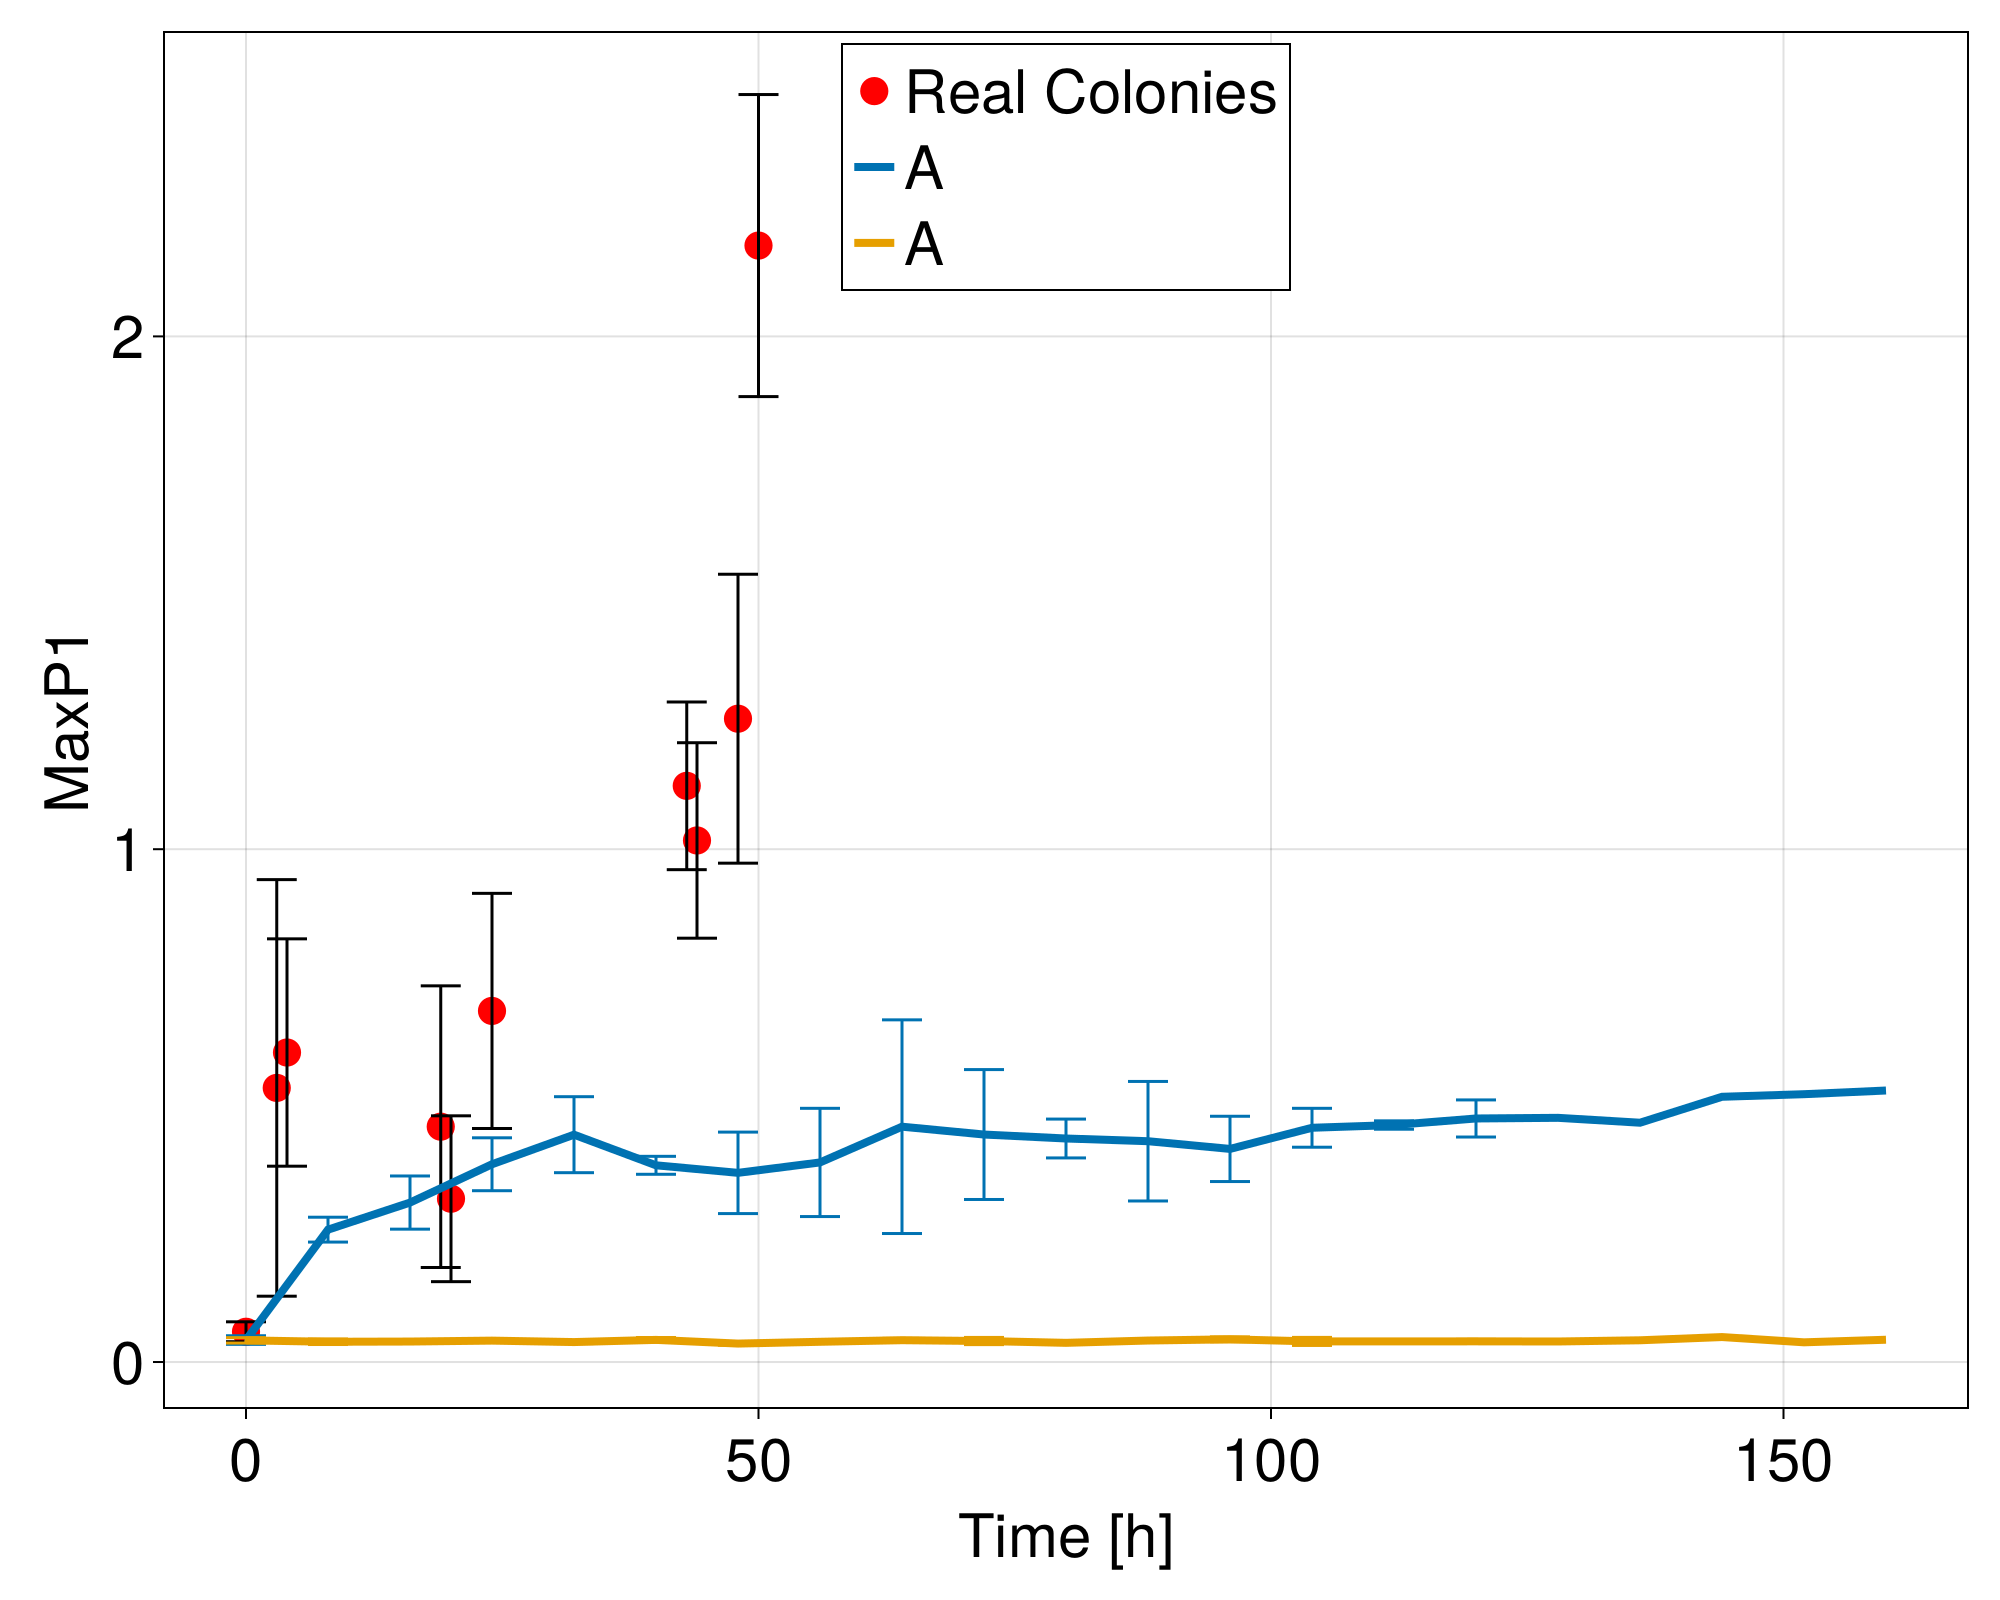

In [10]:
model_name = ["A","B","C"]
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1])
scatter!(ax,pair_max_r.time,pair_max_r.pair_og, markersize = 20, color = "red")
errorbars!(ax,pair_max_r.time,pair_max_r.pair_og, pair_max_r.pair_og_stdd,whiskerwidth = 20, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="MaxP1"
j = 1
for (k, i) in pairs(groupby(pair_max_single_cov,:data_set))
    #lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    lines!(ax, i.time, i.pair_cov, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.pair_cov,i.pair_cov_stdd )
    j += 1
end
j = 1
for (k, i) in pairs(groupby(pair_max_single,:data_set))
    #lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    lines!(ax, i.time, i.pair_og, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :ct)
save(joinpath(path,"Comparision_MaxP1_64.pdf"),fig1)
fig1

## Coefficent of variantion 

In [11]:
cv_angular_max = @chain data_a begin
    groupby(:time)
    @combine(:cv_angu = mean(std.(:metric_OG)./(mean.(:metric_OG))), :cv_angu_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end
first(cv_angular_max,3)

cv_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_OG)./(mean.(:metric_OG))), :cv_angu_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end
first(cv_angular_max_single,3)

Row,time,data_set,cv_angu,cv_angu_std
,Int64,String,Float64,Float64
1,0,Random 2024_03_11,NaN,NaN
2,8,Random 2024_03_11,0.122449,0.00927745
3,16,Random 2024_03_11,0.0799173,0.00249085


In [12]:
cv_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

Row,time,cv_OG,cv_OG_std
,Int64,Float64,Float64
1,0,NaN,NaN
2,3,0.695513,0.237475
3,4,0.720371,0.135934
4,19,0.639922,0.231289
5,20,0.548096,0.151844
6,24,0.818629,0.145498
7,43,1.06527,0.0807563
8,44,1.01741,0.09607
9,48,1.12087,0.124787


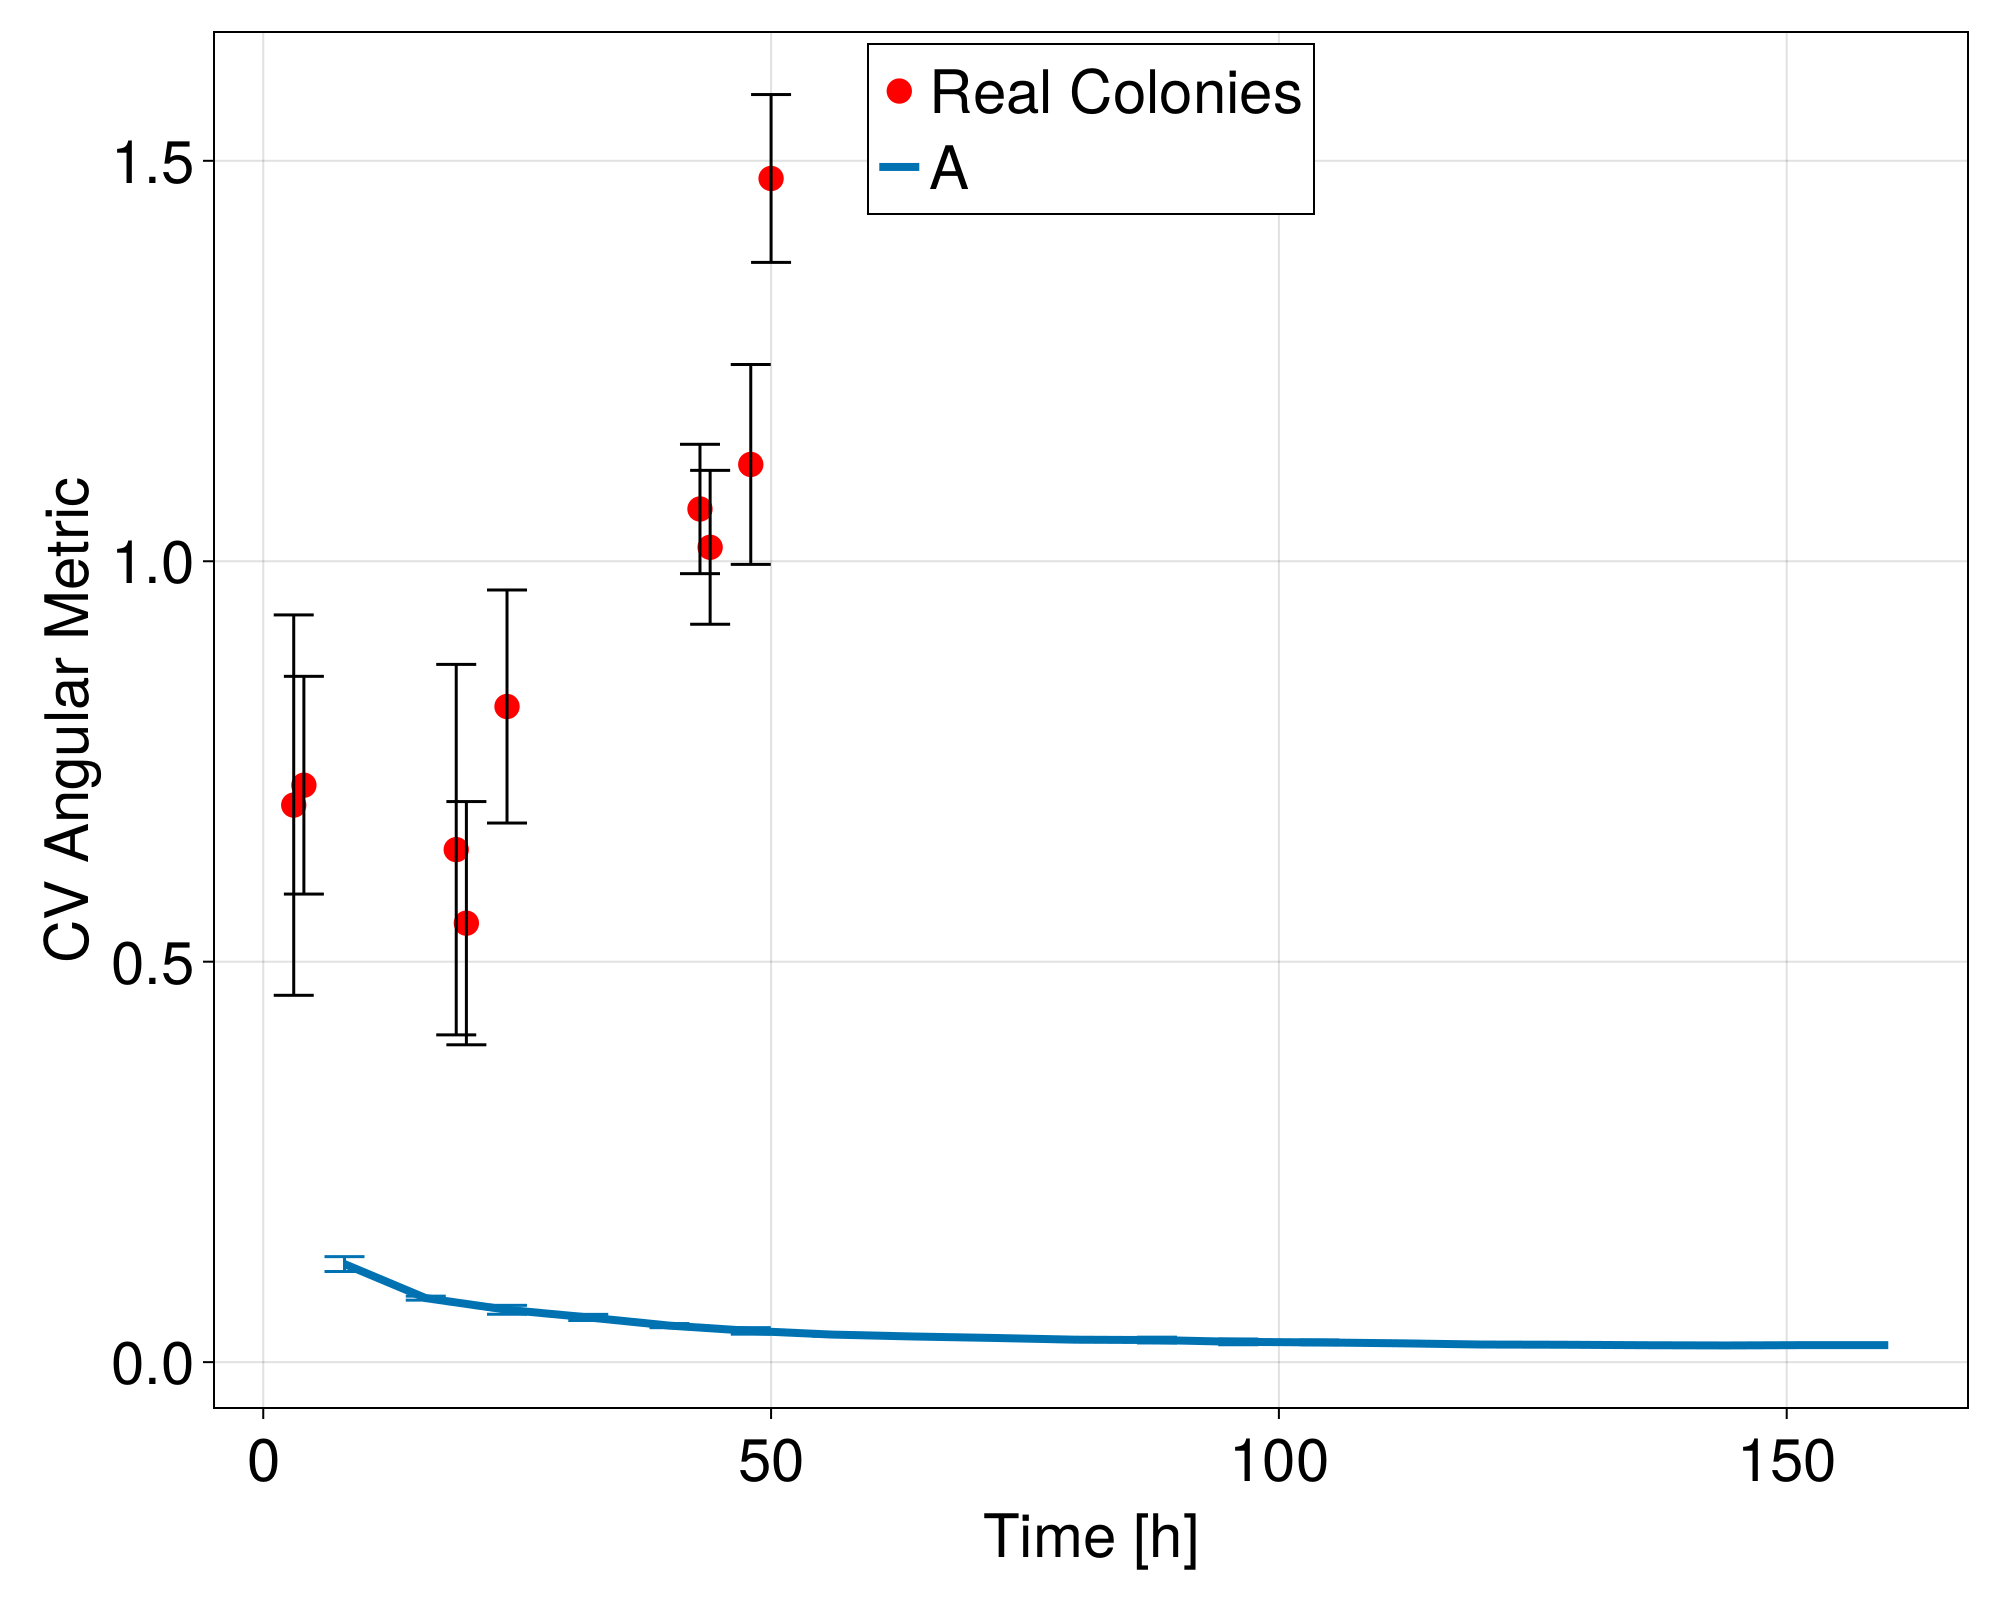

In [13]:
fig3 = Figure()
ax = CairoMakie.Axis(fig3[1,1])
scatter!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, color = :red)
errorbars!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, cv_angular_max_r.cv_OG_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    #lines!(ax, i.time, i.cv_angu, label  = mk_label(k.data_set))
    lines!(ax,  i.time, i.cv_angu, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.cv_angu,i.cv_angu_std )
    j += 1
end
axislegend(ax, position = :ct)
save(joinpath(path,"Comparision_CV_64.pdf"),fig3)
fig3

## Root mean square fluctations/roughness

In [14]:
roughness_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = mean(std.(:metric_cov)),:roughness_angu_std = std(std.(:metric_cov)))
end
first(roughness_angular_max_single)

Row,time,data_set,roughness_angu,roughness_angu_std
,Int64,String,Float64,Float64
1,0,Random 2024_03_11,6.19249,0.0


In [15]:
unique(roughness_angular_max_single.data_set)

1-element Vector{String}:
 "Random 2024_03_11"

In [23]:
roughness_angular_max_single

Row,time,data_set,roughness_angu,roughness_angu_std
,Int64,String,Float64,Float64
1,0,Random 2024_03_11,6.19249,0.0
2,8,Random 2024_03_11,4.81117,0.70215
3,16,Random 2024_03_11,7.05625,0.292518
4,24,Random 2024_03_11,10.335,1.40148
5,32,Random 2024_03_11,14.0632,1.59617
6,40,Random 2024_03_11,15.4888,1.84234
7,48,Random 2024_03_11,18.3623,2.34446
8,56,Random 2024_03_11,22.1243,3.07975
9,64,Random 2024_03_11,27.6517,3.06542


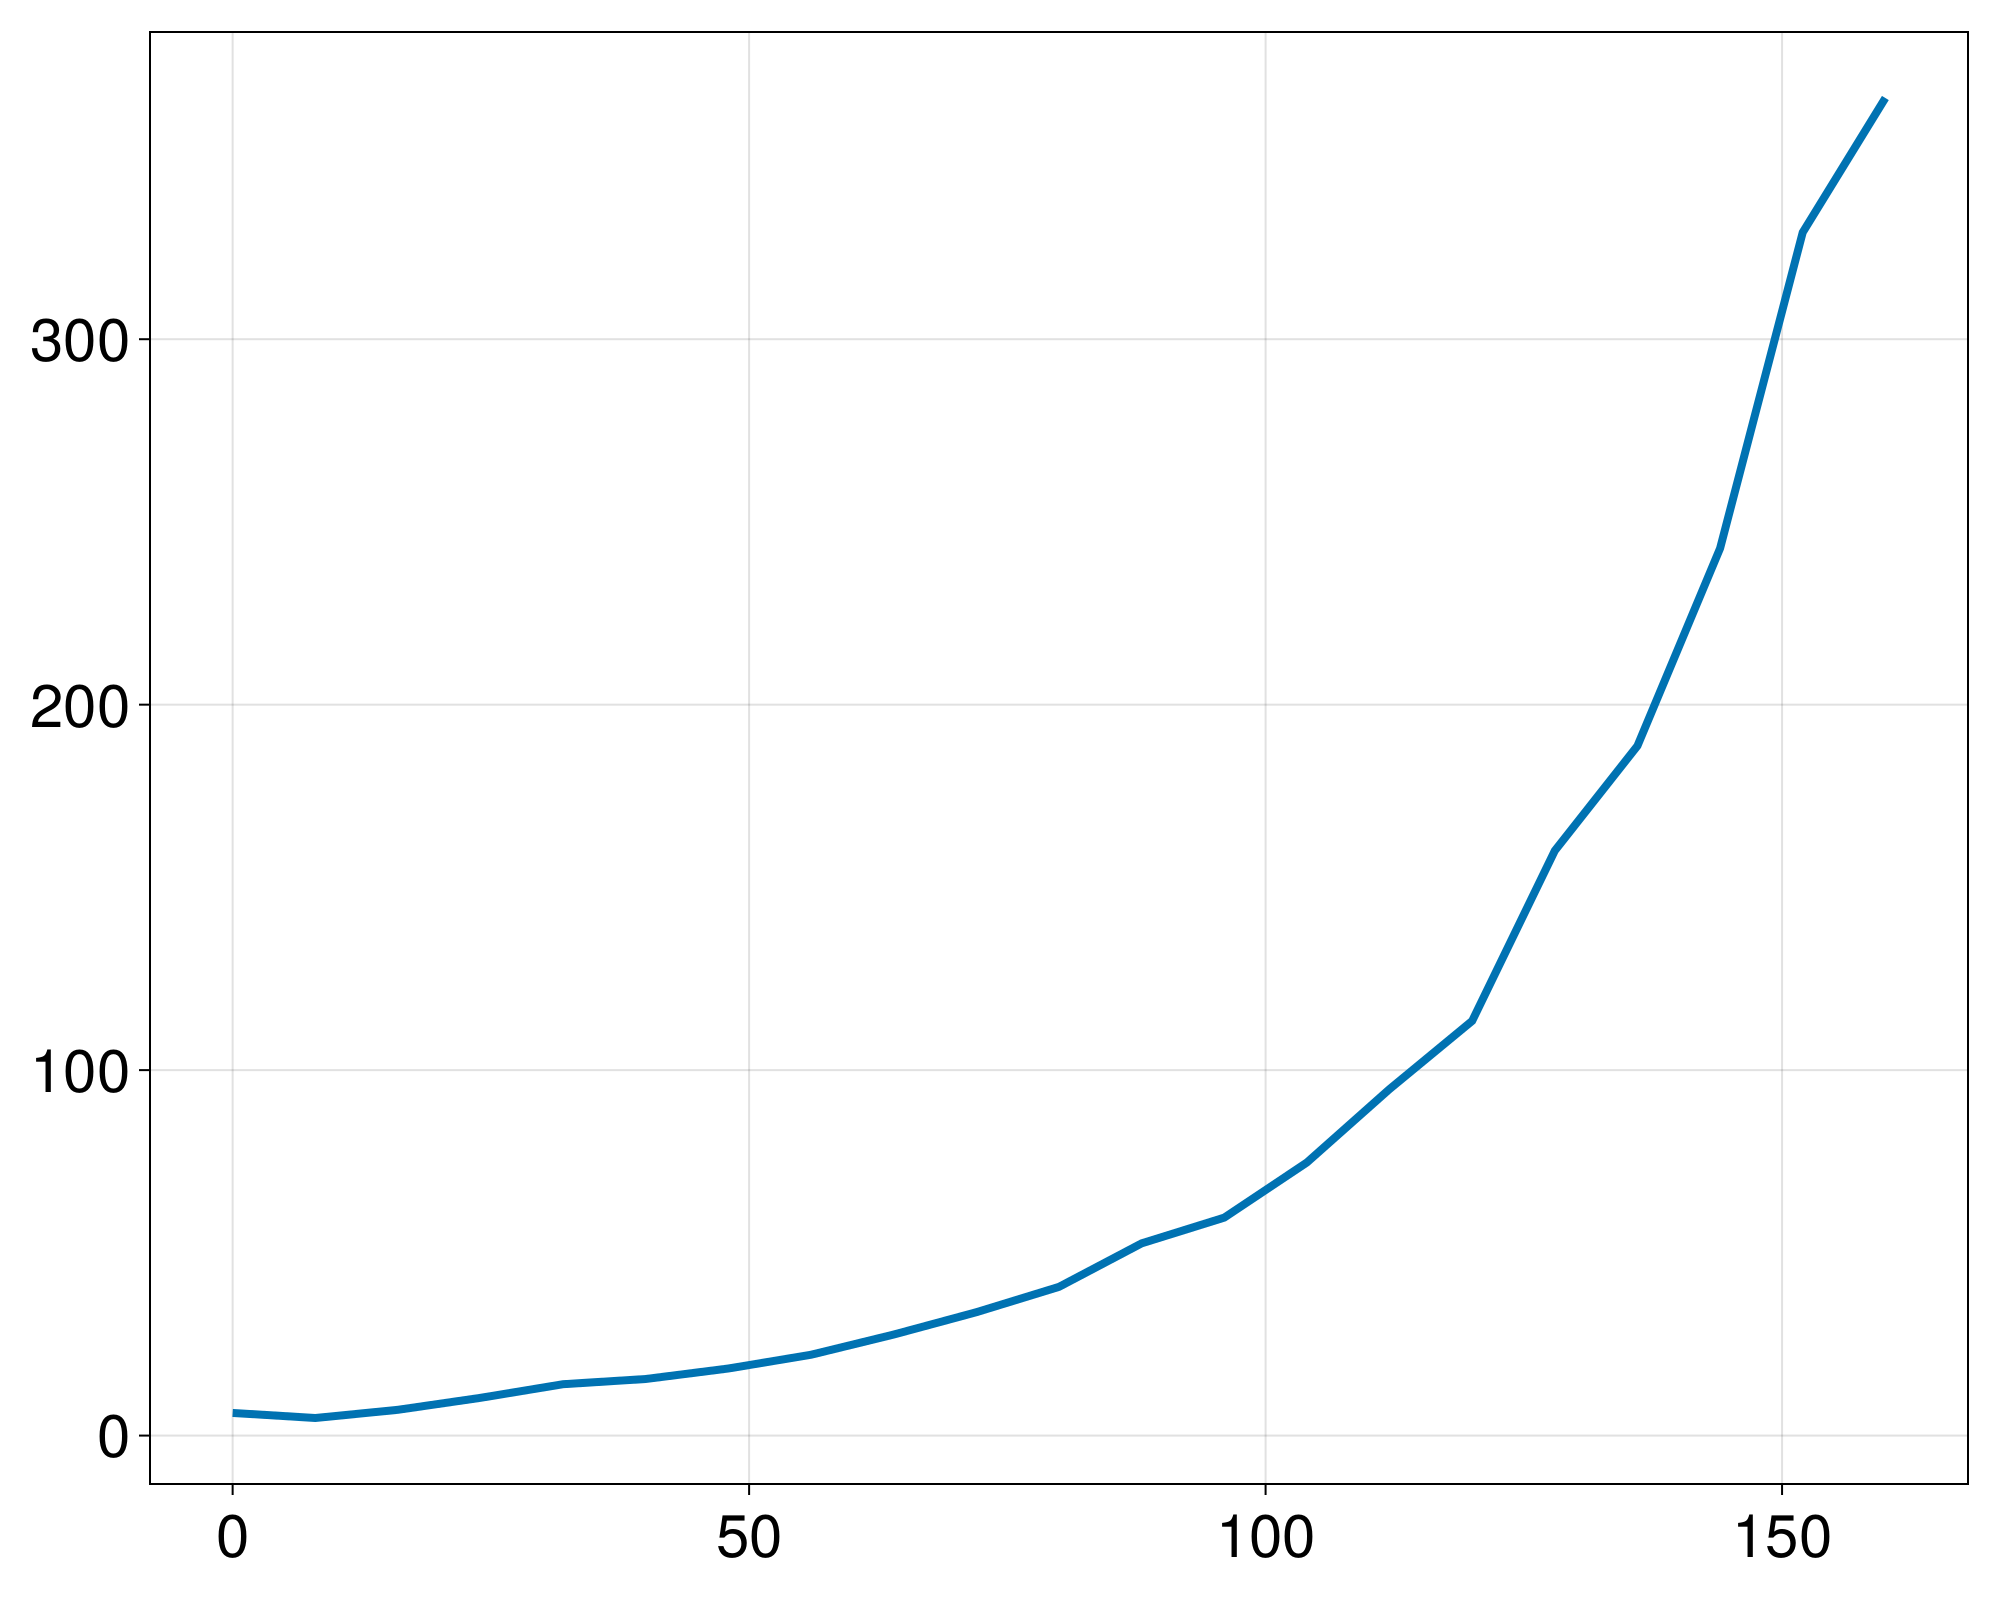

In [22]:
a  = @subset(roughness_angular_max_single, :data_set .== "Random 2024_03_11");
lines(a.time, a.roughness_angu, label = "Random 2024_03_11")

In [17]:
roughness_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG)),:roughness_OG_std = std(std.(:metric_OG)))
end

Row,time,roughness_OG,roughness_OG_std
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,4.52467,4.76343
3,4,3.01044,1.35788
4,19,34.7599,21.9436
5,20,23.0157,7.95766
6,24,48.8446,23.8872
7,43,181.523,33.9552
8,44,151.611,29.2072
9,48,185.017,52.0155


In [18]:
roughness_angular_right_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = (mean(var.(:metric_OG, corrected = false)))^(1/2),:roughness_angu_std = (std(var.(:metric_OG, corrected = false)))^(1/2))
end
first(roughness_angular_right_single)

Row,time,data_set,roughness_angu,roughness_angu_std
,Int64,String,Float64,Float64
1,0,Random 2024_03_11,0.0,0.0


In [19]:
roughness_angular_right = @chain data_full begin
    groupby([:time])
    @combine(:roughness_OG = (mean(var.(:metric_OG, corrected = false)))^(1/2),:roughness_OG_std = (std(var.(:metric_OG, corrected = false)))^(1/2))
end

Row,time,roughness_OG,roughness_OG_std
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,6.34149,9.42132
3,4,3.25113,2.99457
4,19,40.312,40.1648
5,20,24.1014,19.0775
6,24,54.1514,53.4661
7,43,184.024,111.979
8,44,153.724,95.1588
9,48,191.671,142.986


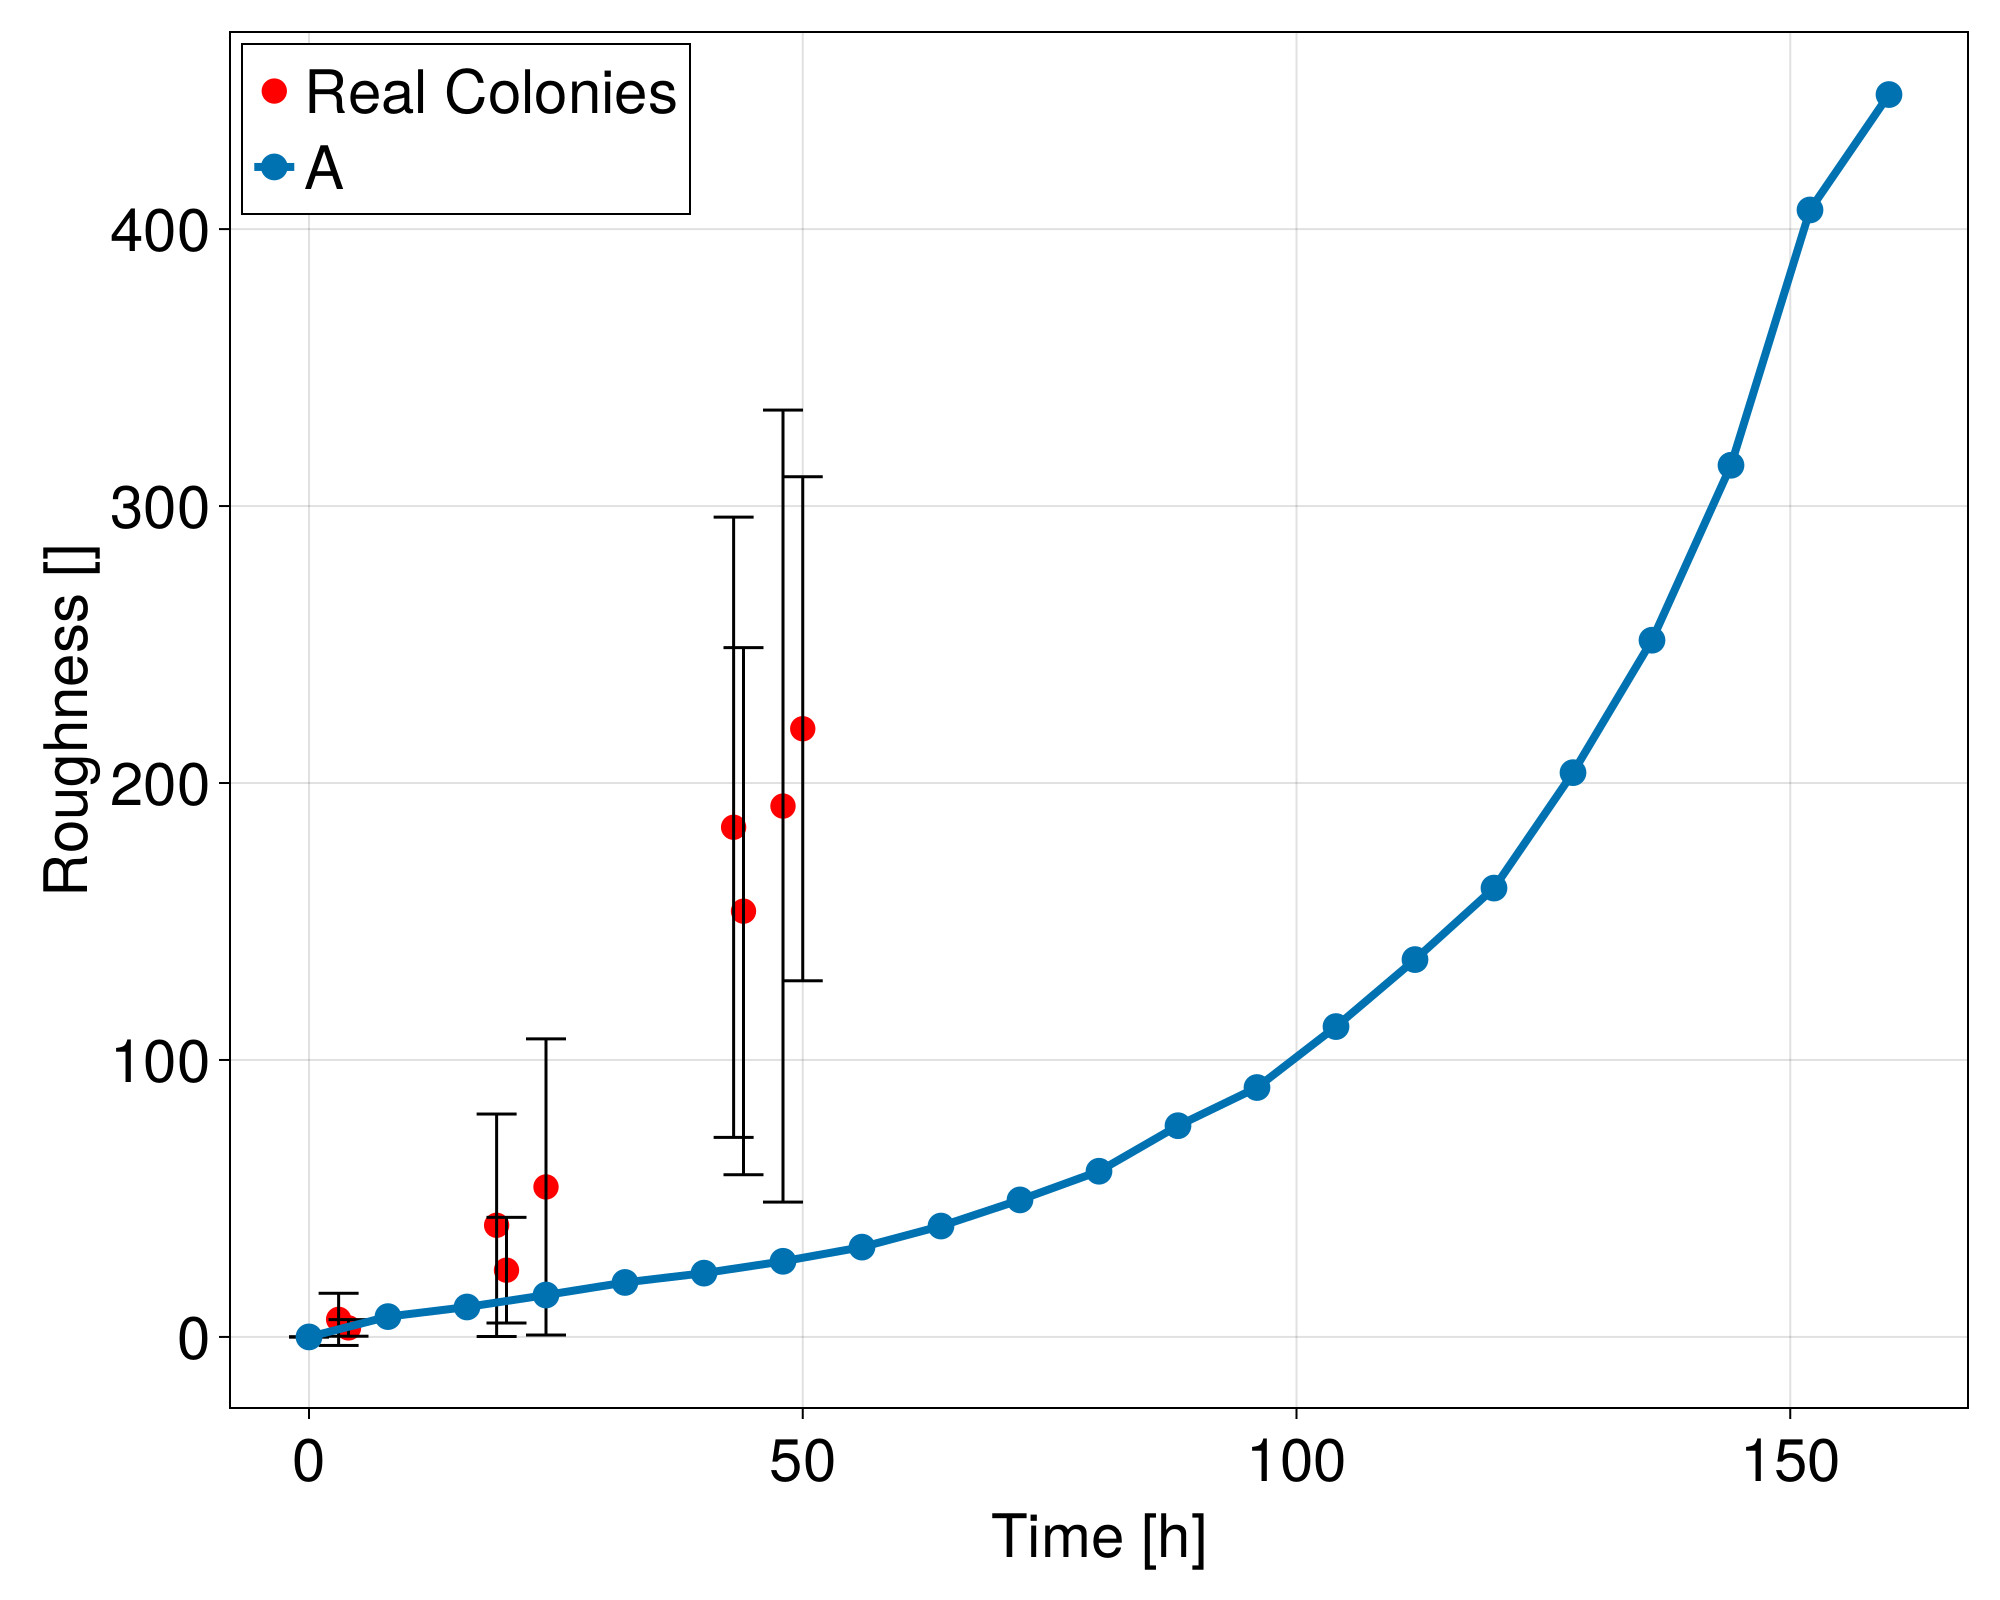

In [20]:
fig31 = Figure()
ax = CairoMakie.Axis(fig31[1,1])
scatter!(ax,roughness_angular_right.time,roughness_angular_right.roughness_OG, color = "red")
errorbars!(ax,roughness_angular_right.time,roughness_angular_right.roughness_OG, roughness_angular_right.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_right_single,:data_set))
    #lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    scatterlines!(ax, i.time, i.roughness_angu, label = model_name[j],linewidth = 4,markersize  = 19)
    #errorbars!(ax, i.time, i.roughness_angu,i.roughness_angu_std )
    j += 1
end
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_interface_width.pdf"),fig31)
fig31

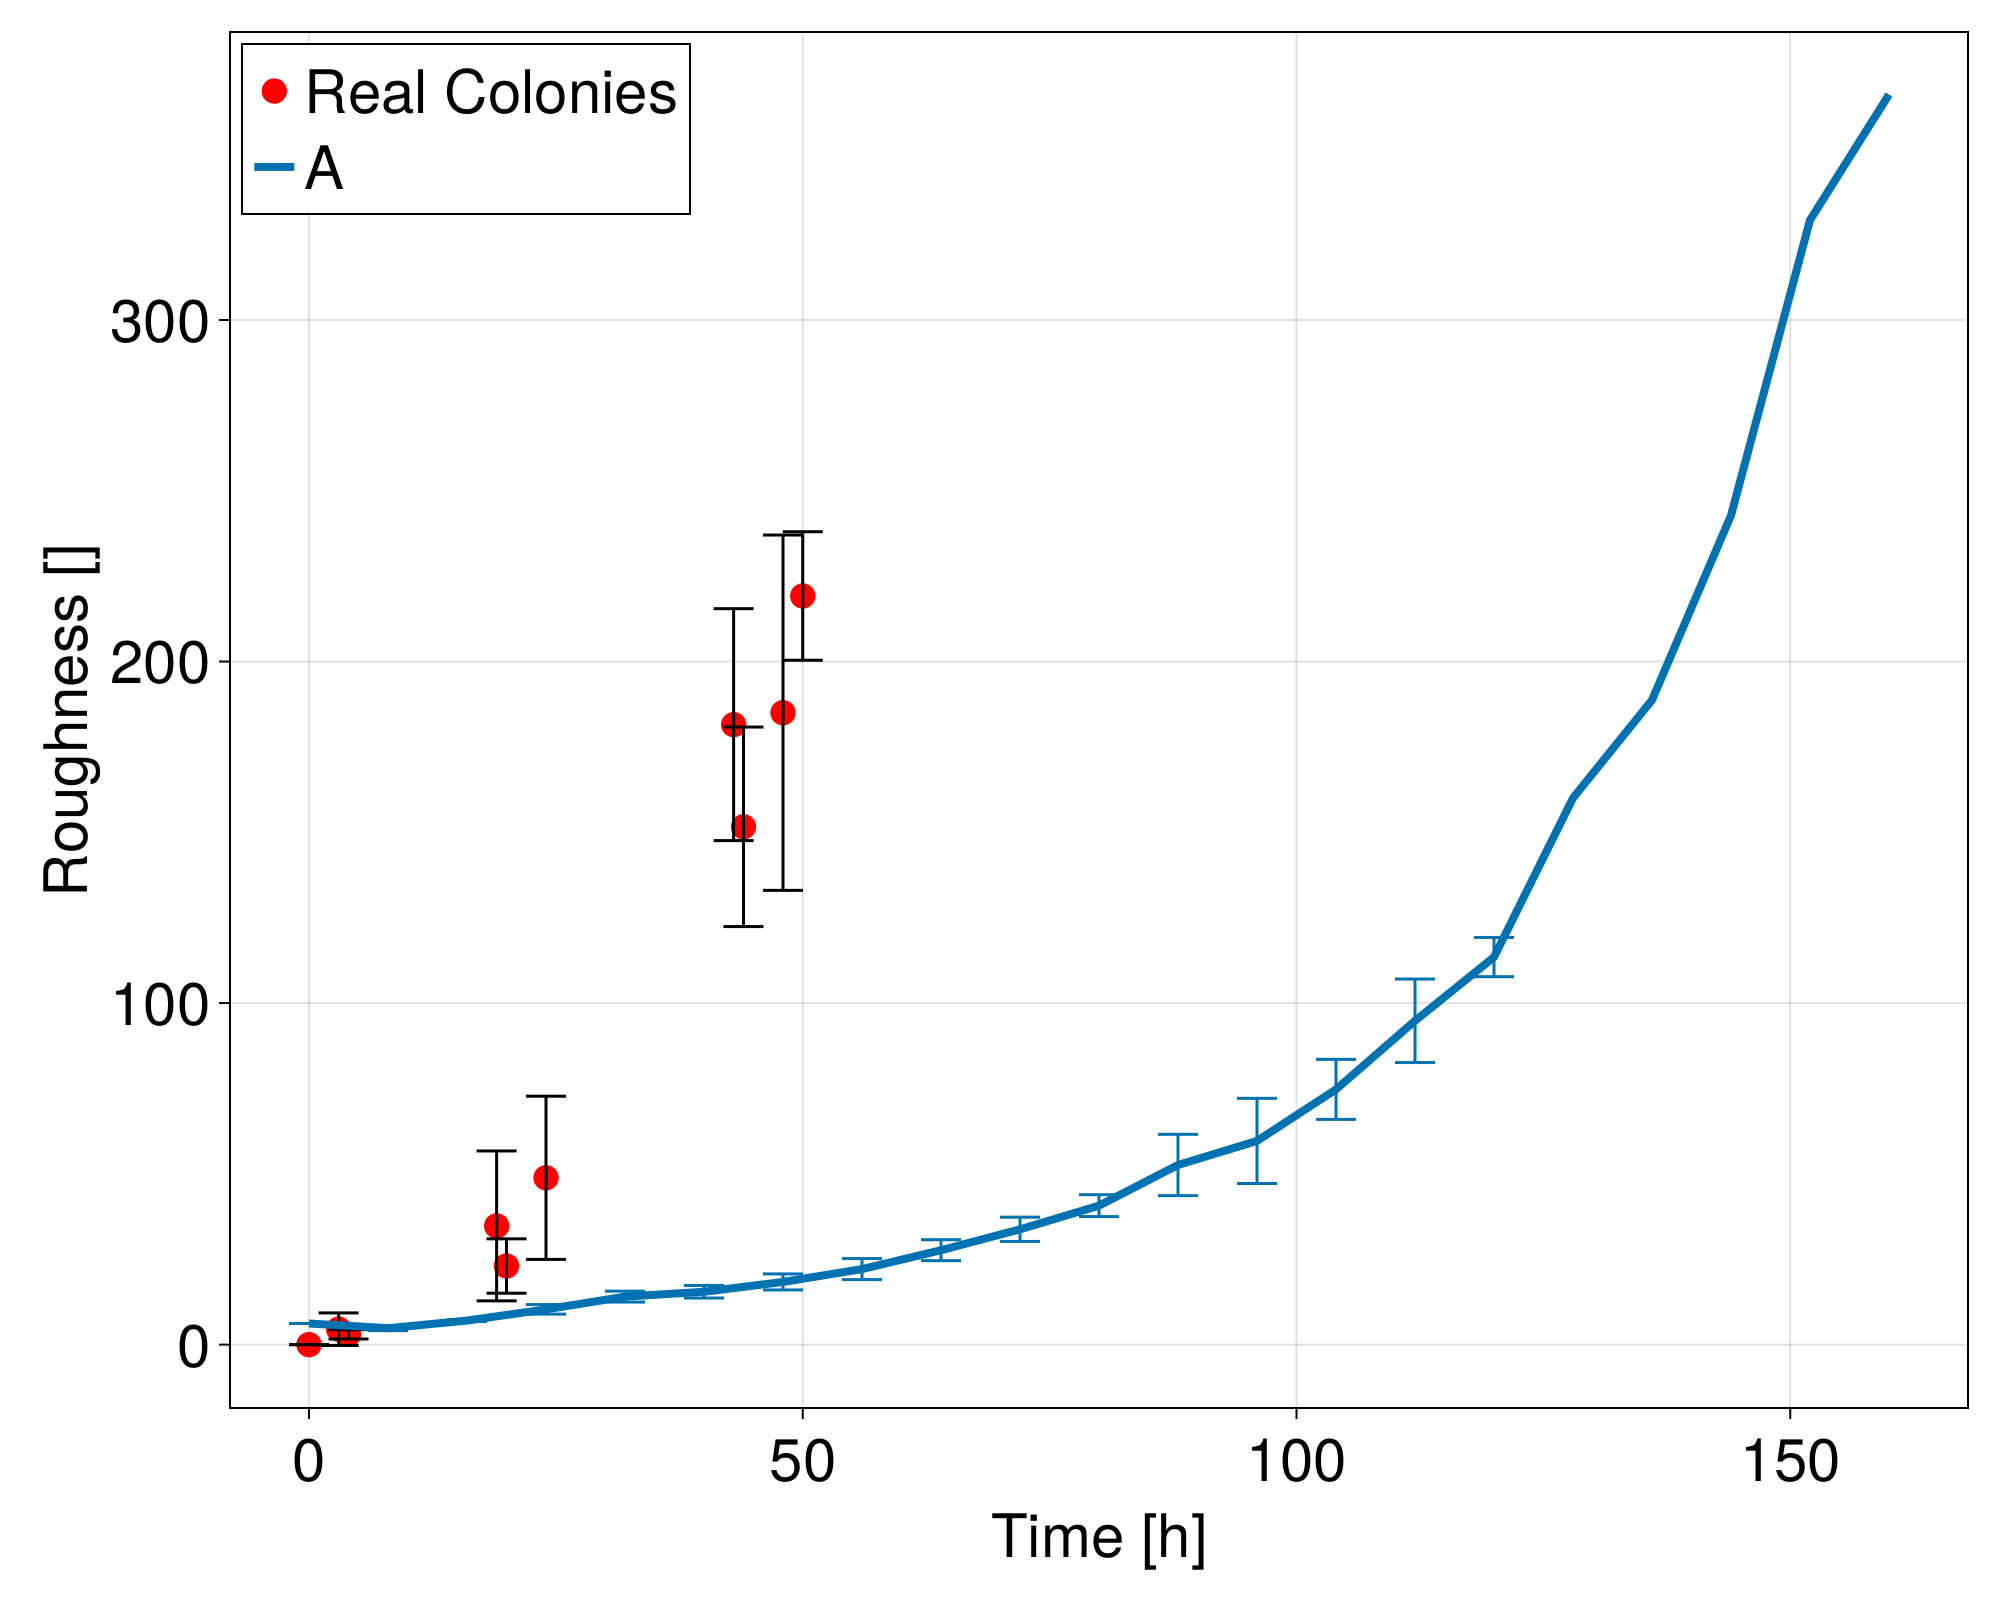

In [21]:
fig30 = Figure()
ax = CairoMakie.Axis(fig30[1,1])
scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, color = "red")
errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    #lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    lines!(ax, i.time, i.roughness_angu, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.roughness_angu,i.roughness_angu_std )
    j += 1
end
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_RMS_64.pdf"),fig30)
fig30

## Fourier Transform on data set 

In [31]:
fft_data = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

fft_data_all = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[1:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

fft_data_r = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end

fft_data_r_all = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[1:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data_r)
     


Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [32]:
sum(sum.(fft_data.abs_OG_n))

12455.184093874646

In [33]:
sum(sum.(fft_data_all.abs_OG_n))

18289.362740354438

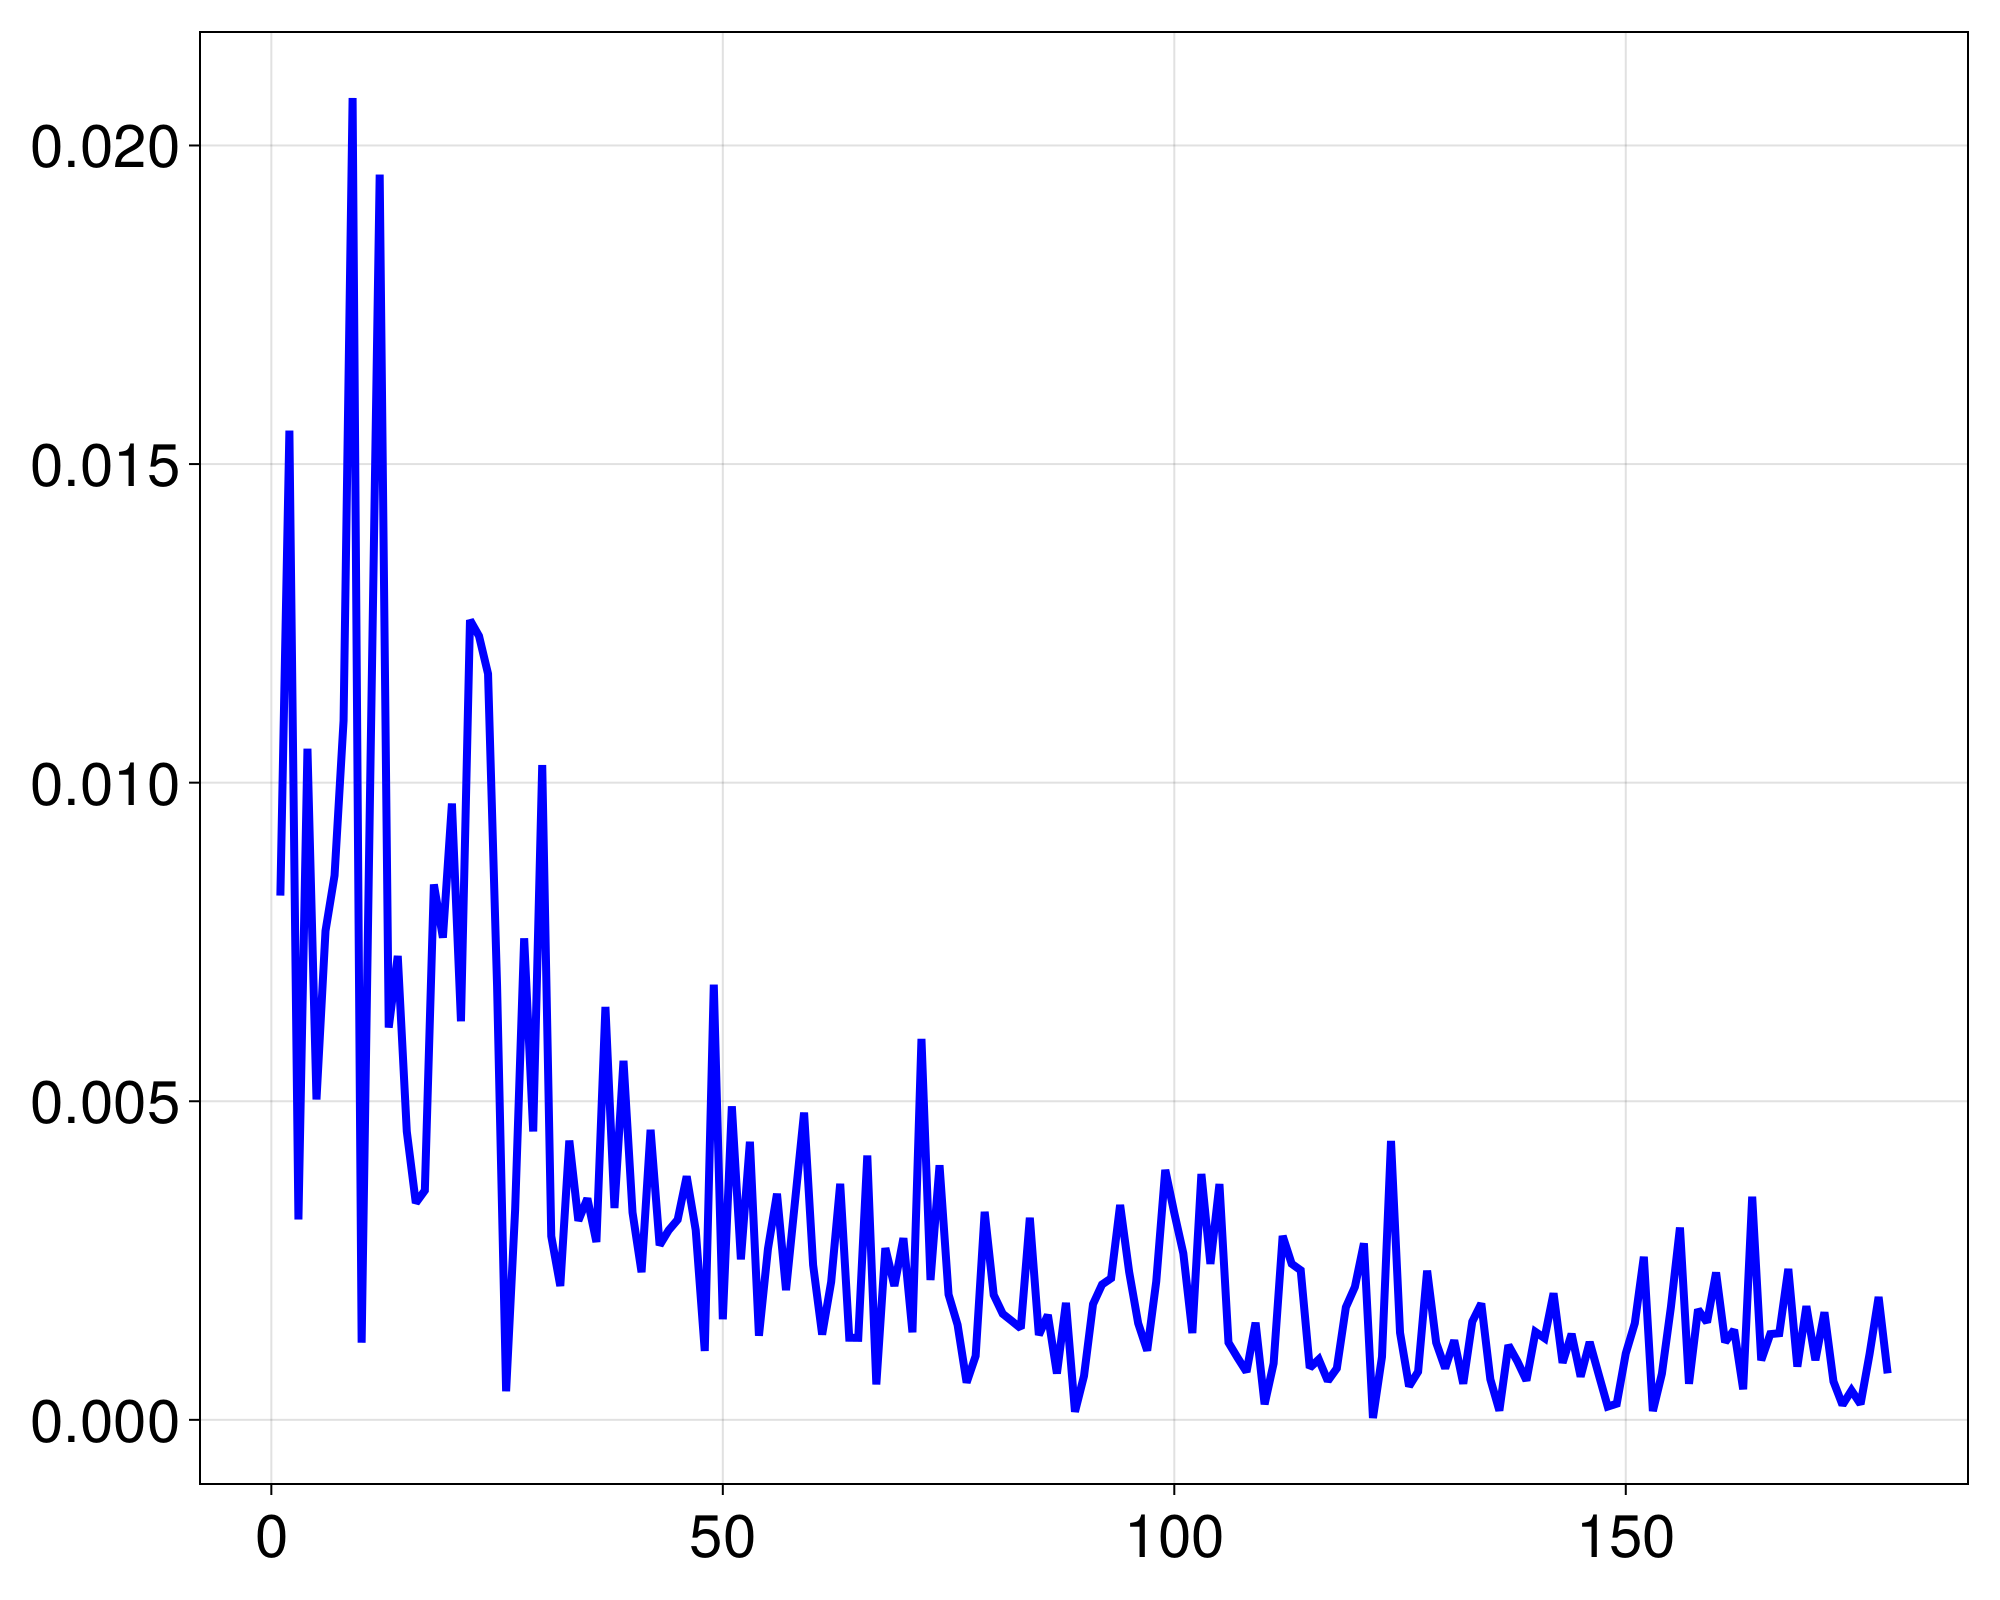

In [34]:
lines(fft_data.abs_OG_n[20], color = :blue)

In [35]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n))
    ,:abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
first(abs_fftw,3)

abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),
    :abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
last(abs_fftw_single,3)

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_std,abs_cov_std,abs_og_n_std,abs_cov_n_std
,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,44,Finger_strong 2024_03_08,8.77791e5,8.76476e5,10.7872,10.7711,51083.0,51203.4,0.627764,0.629243
2,46,Finger_strong 2024_03_08,9.43007e5,9.41673e5,11.5887,11.5723,54816.3,54852.6,0.673642,0.674089
3,48,Finger_strong 2024_03_08,1.0063e6,1.00494e6,12.3665,12.3498,52075.8,52200.6,0.639965,0.641498


In [36]:
abs_fftw_all = @chain fft_data_all begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n))
    ,:abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
first(abs_fftw,3)

abs_fftw_single_all = @chain fft_data_all begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),
    :abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
last(abs_fftw_single_all,3)

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_std,abs_cov_std,abs_og_n_std,abs_cov_n_std
,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,44,Finger_strong 2024_03_08,1.09239e6,1.09143e6,13.4245,13.4127,51067.7,51227.8,0.627576,0.629543
2,46,Finger_strong 2024_03_08,1.17546e6,1.17446e6,14.4453,14.4331,54820.9,54881.7,0.673699,0.674446
3,48,Finger_strong 2024_03_08,1.25768e6,1.25666e6,15.4558,15.4432,52083.9,52225.7,0.640064,0.641807


In [37]:
abs_fftw_r_all = @chain fft_data_r_all begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r_all,5)

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_n_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,24,1.05275e5,98447.7,5.23896,4.9021,2.06074
2,43,3.79381e5,3.67919e5,13.4943,13.0836,4.25813
3,44,3.1484e5,3.03466e5,20.6009,19.8613,3.44611
4,48,3.92854e5,3.84029e5,19.0877,18.6851,5.80726
5,50,4.19777e5,4.12892e5,24.9564,24.5467,3.08023


In [38]:
abs_fftw_r = @chain fft_data_r begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r,5)

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_n_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,24,84390.7,83534.8,4.18188,4.13021,1.72475
2,43,3.18116e5,3.16579e5,11.3236,11.2641,3.72263
3,44,2.61143e5,2.59082e5,17.0809,16.9521,3.08389
4,48,3.32596e5,3.30848e5,16.1378,16.0472,4.90487
5,50,3.6632e5,3.64281e5,21.7879,21.6687,2.94679


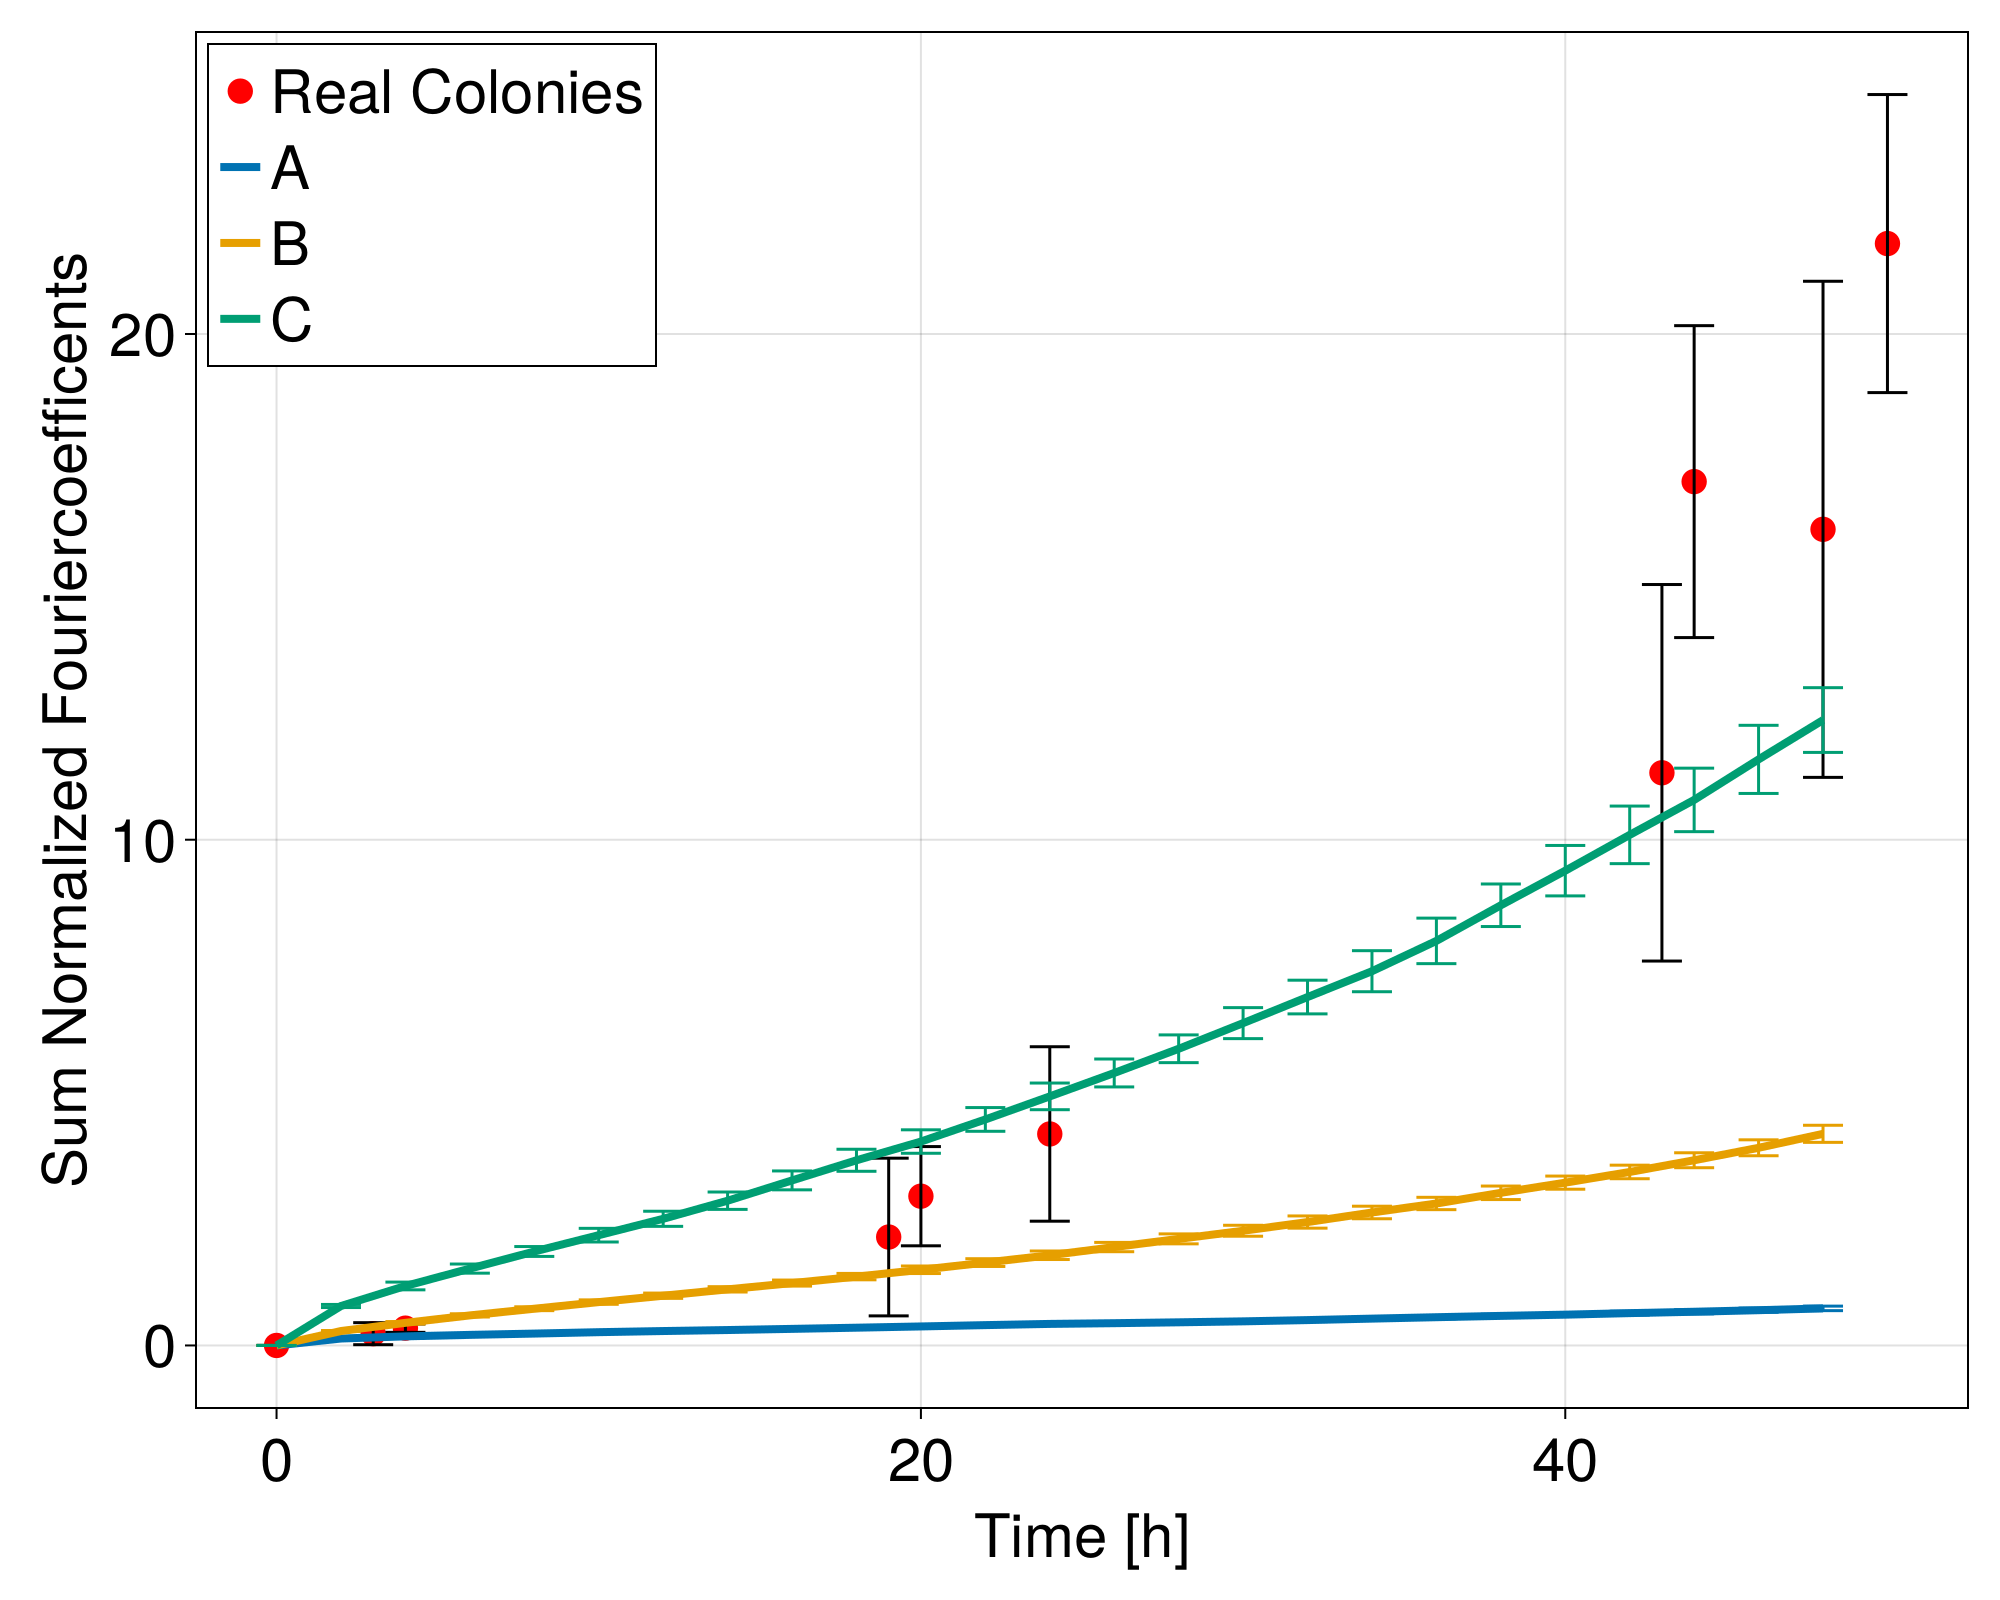

In [39]:
fig5 = Figure()
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    #lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    lines!(ax, i.time, i.abs_og_n, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff_64.pdf"),fig5)
fig5

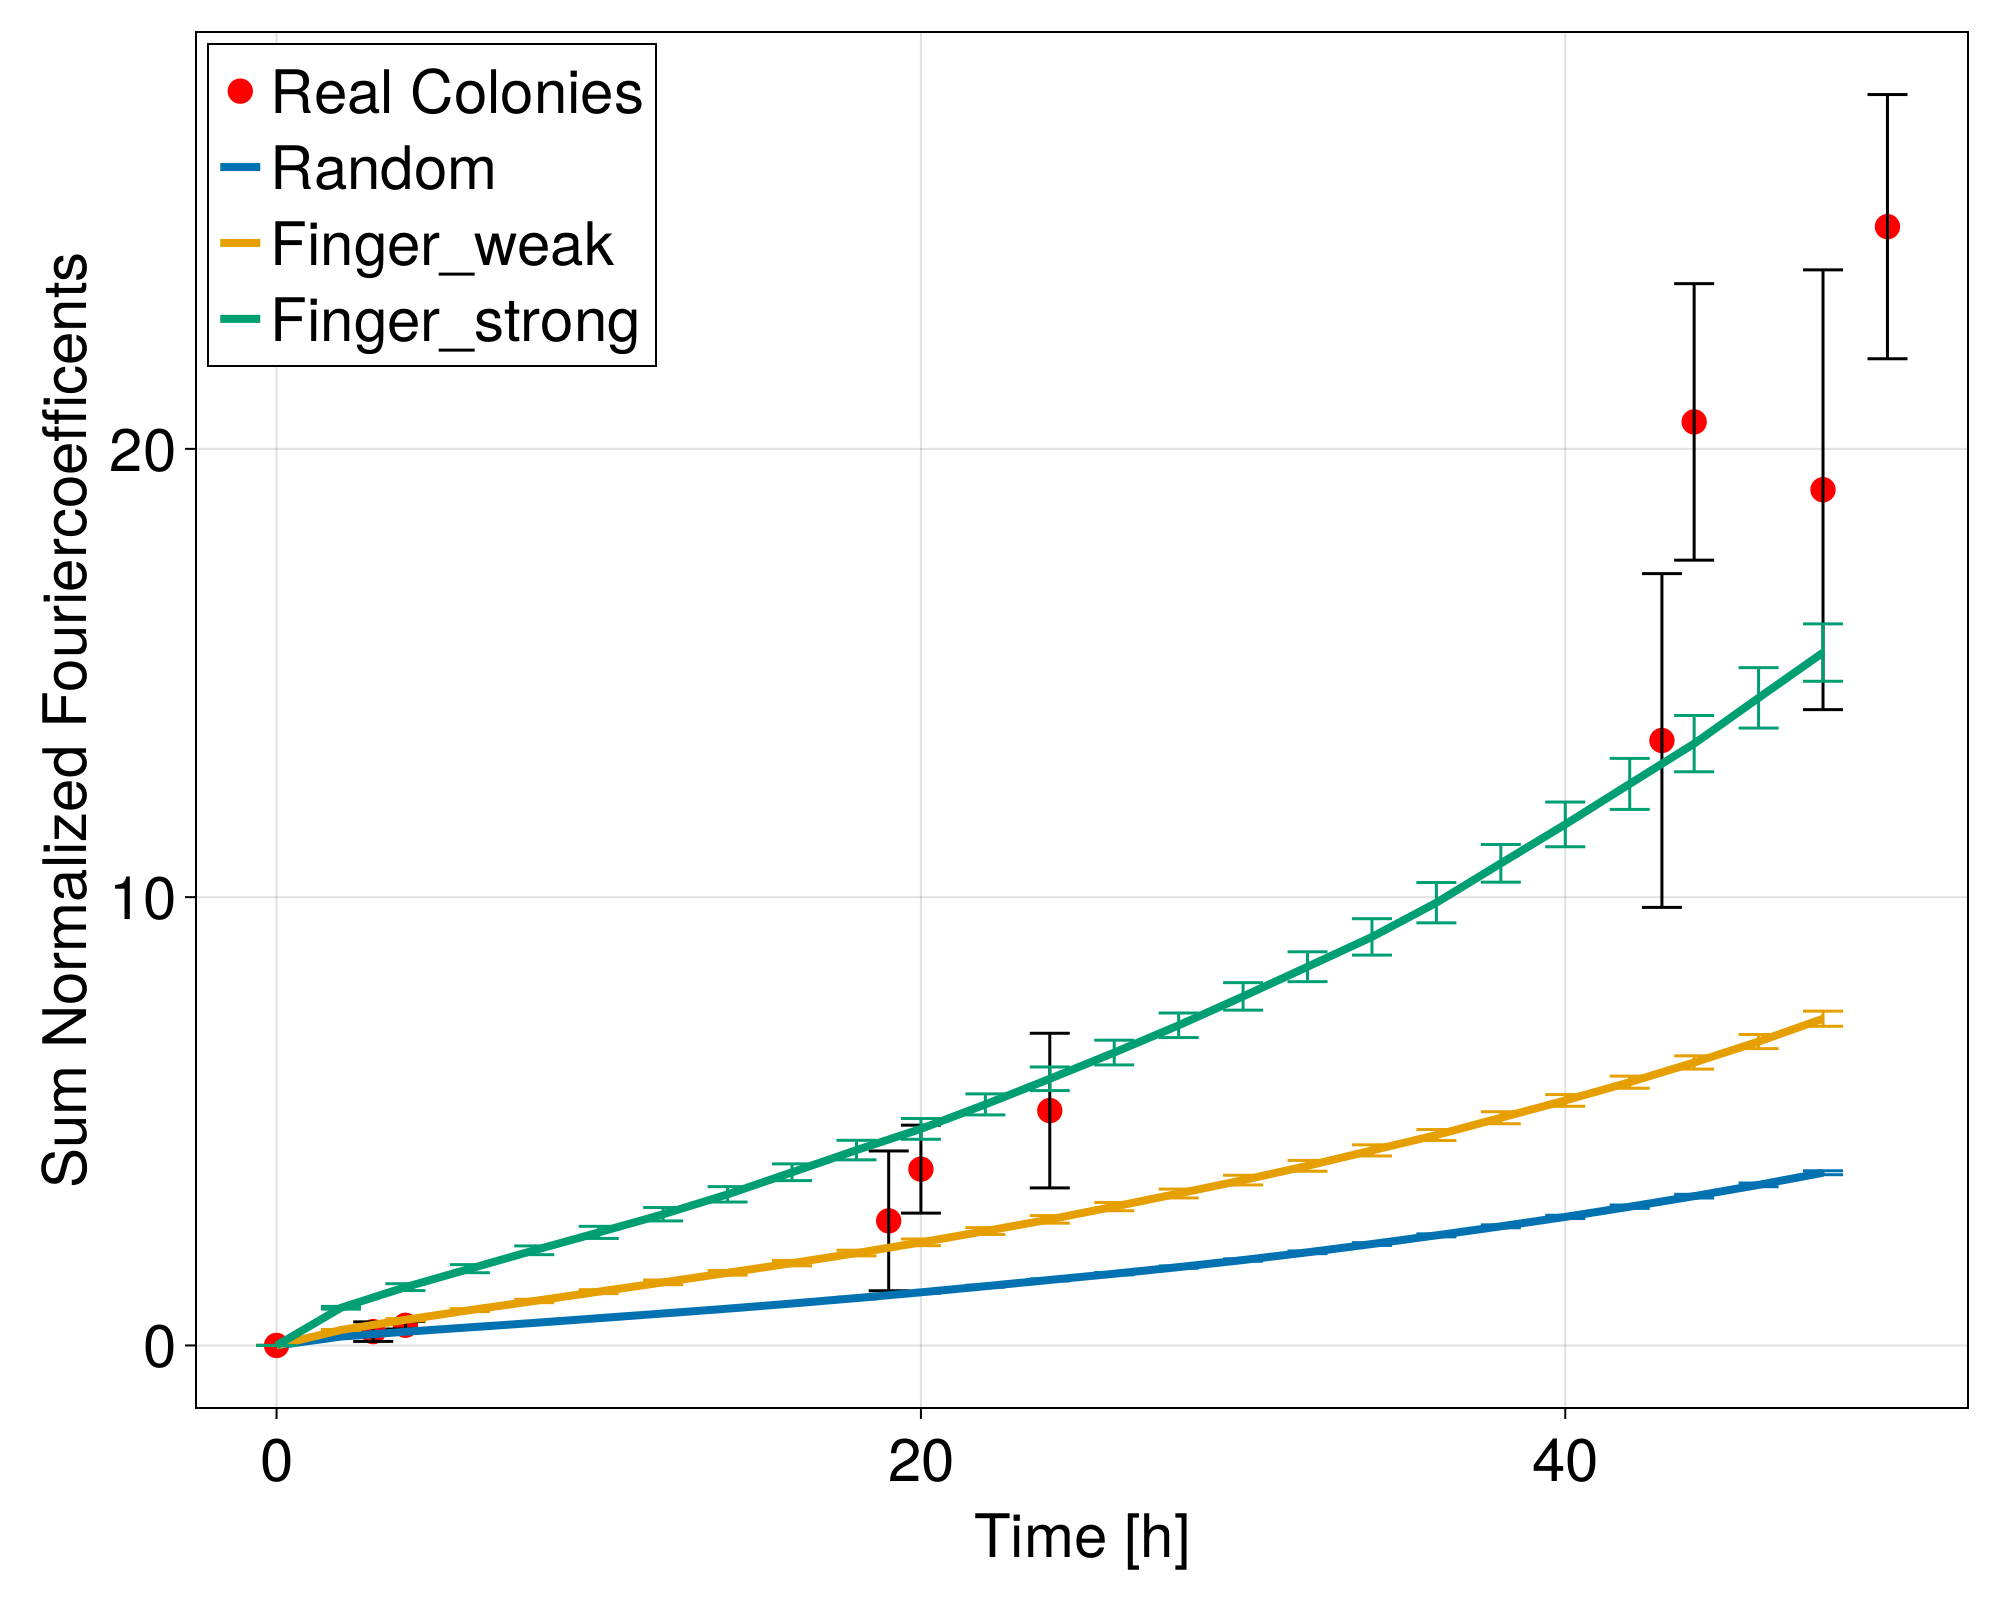

In [40]:
fig5 = Figure()
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r_all.time, abs_fftw_r_all.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r_all.time, abs_fftw_r_all.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single_all,:data_set))
    lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff_64_0.pdf"),fig5)
fig5

In [41]:
all_frequ = vcat(filter_fourier_beta.(fft_data.abs_OG_n)...);
fft_data_r_old = @subset(fft_data_r, :time .> 10)
fft_data_a_old = @subset(fft_data, :time .> 10);

In [35]:
histo_data_r = vcat(find_freq.(filter_fourier_beta.(fft_data_r.abs_OG_n, b  =0.5))...);

In [36]:
#median(histo_data_r)

In [37]:
mean(histo_data_r)


14.218543046357615

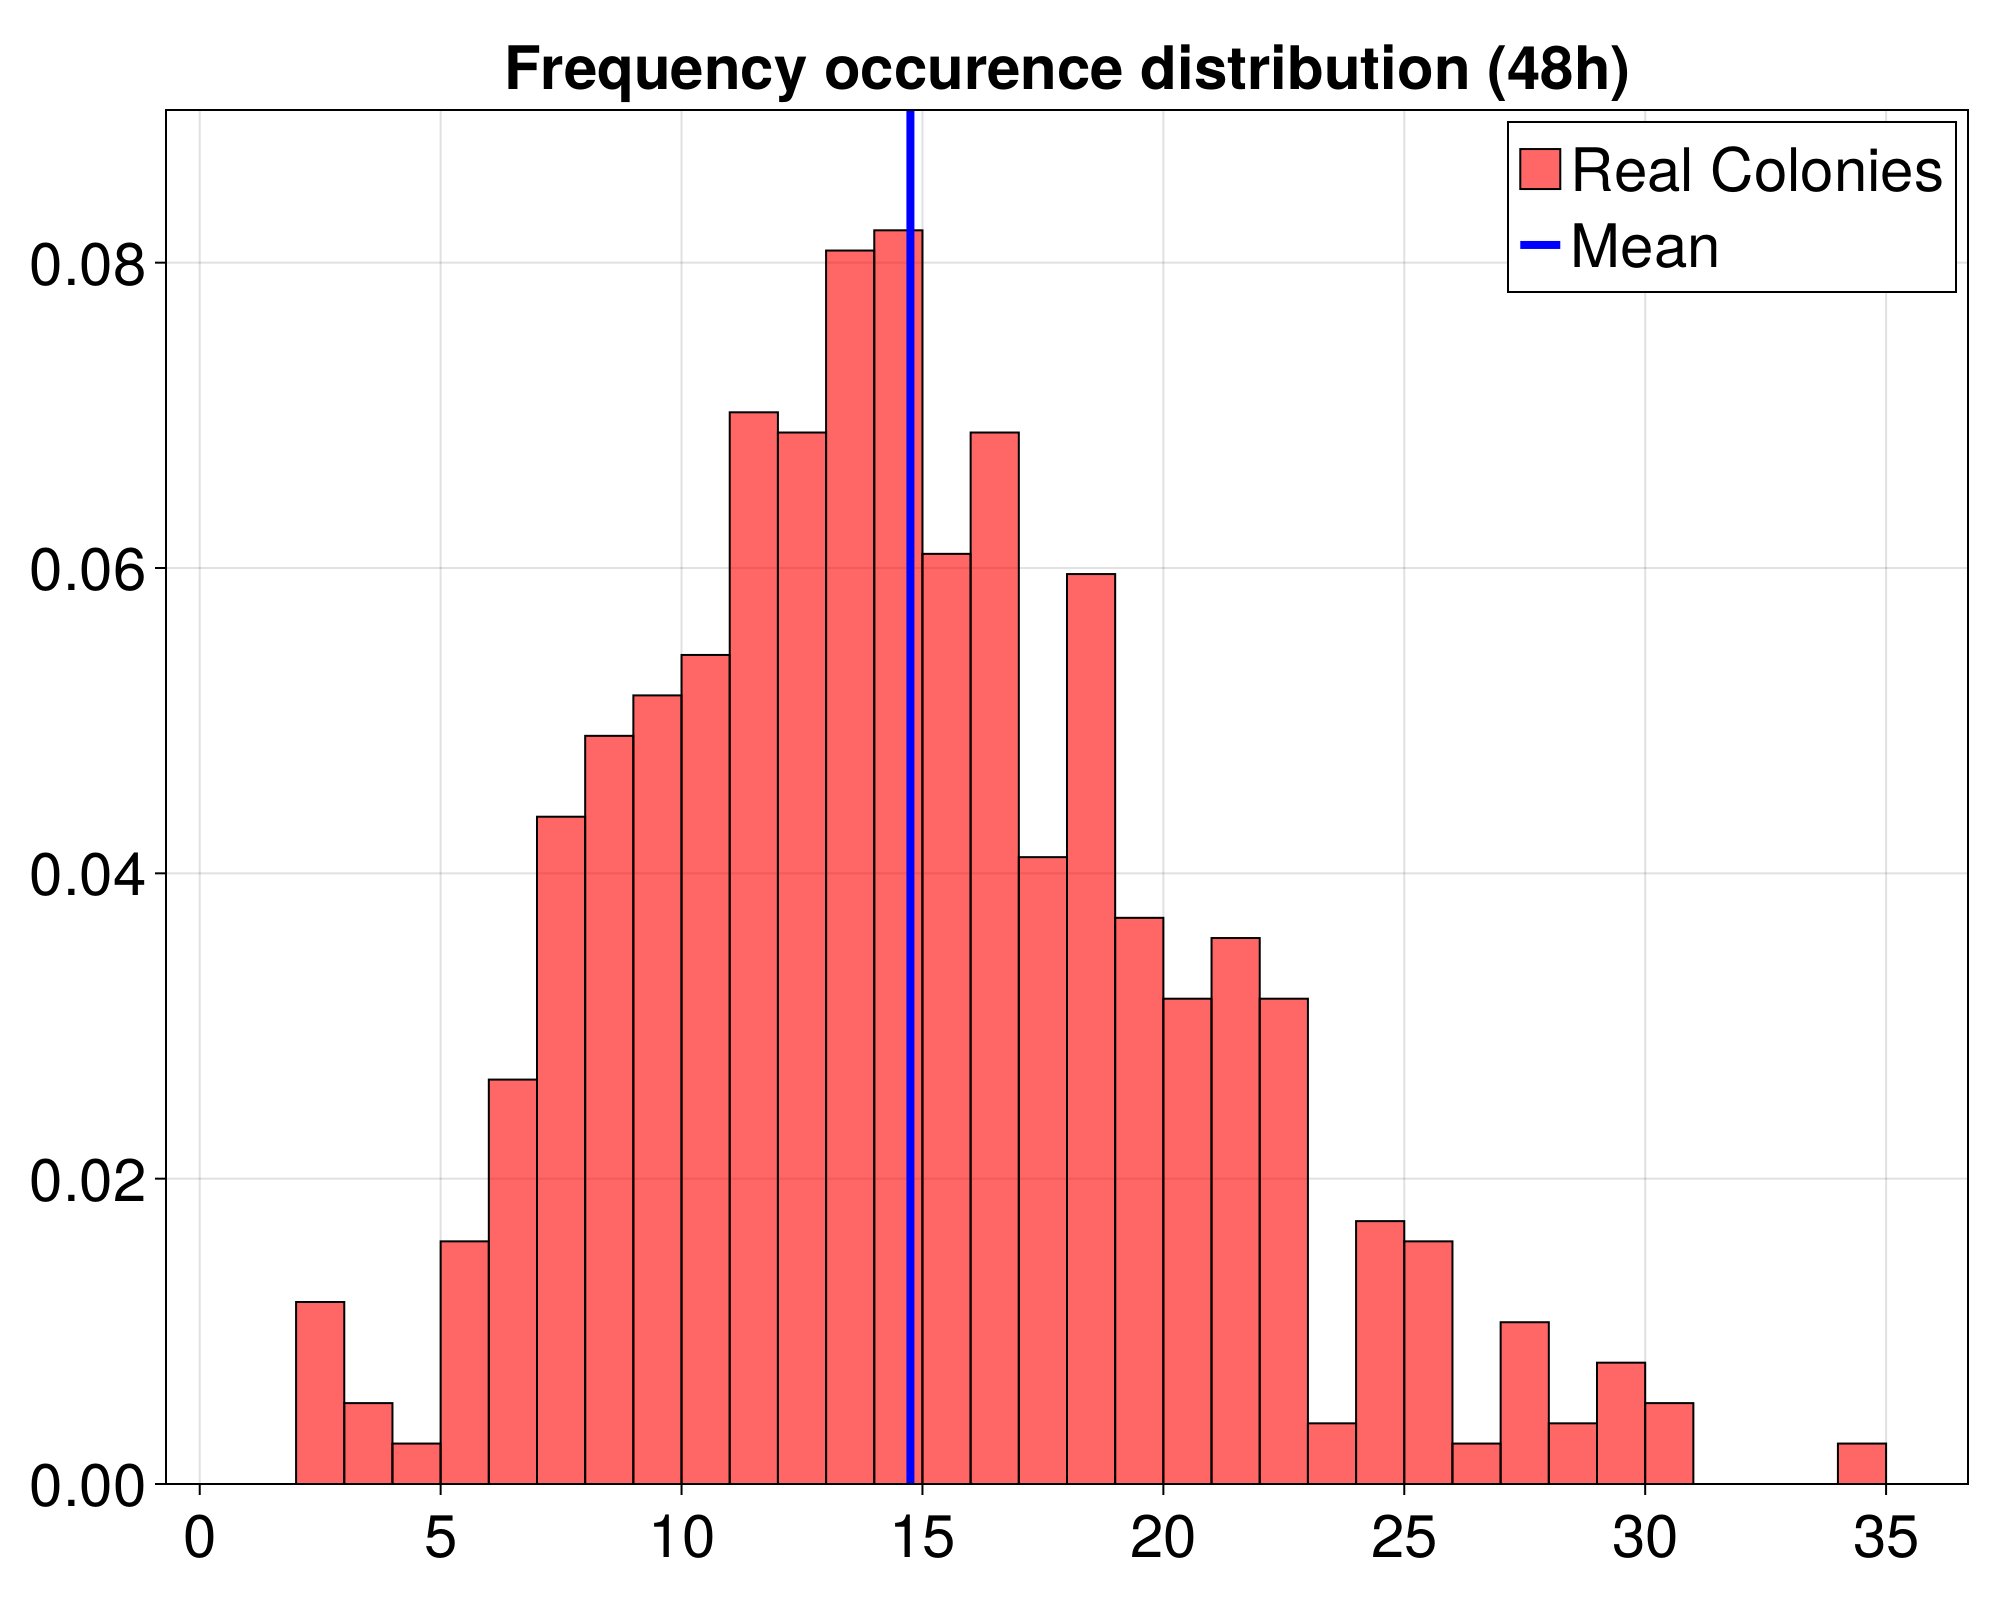

In [38]:
histo_data_a_vec = []
color_vec =[:green, :blue, :yellow, :orange, :purple, :black, :pink, :cyan, :magenta]



hans = Figure()
ax = Axis(hans[1,1])
ylims!(ax,0,0.09)
histi = hist!(ax,histo_data_r, bins = 1:35,strokewidth = 1, color = (:red, 0.6), label = "Real Colonies",normalization = :pdf)
c = 1

"""
for (k,i) in pairs(groupby(fft_data_a_old,:data_set))
    push!(histo_data_a_vec, vcat(find_freq.(filter_fourier_beta.(i.abs_OG_n, b  =0.5))...))
    hist!(ax,histo_data_a_vec[end], bins = 1:40,strokewidth = 1, color = (color_vec[c], 0.3), label = mk_label(k.data_set),normalization = :pdf)
    c += 1
end
"""

vlines!(ax, 14.75, ymin = 0.00,ymax = 1.0, color = :blue, linewidth = 4, label = "Mean")
ax.title =  "Frequency occurence distribution (48h)"
ax.xticks = 0:5:35
axislegend( position = :rt,)

save(joinpath(path,"frequ_dist_64.pdf"),hans)
hans

### Size increase measure in pixel in circular metric

In [59]:
first(data_full)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675


In [61]:
size_data = @chain data_full begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_OG)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
end

Row,time,abs_size,abs_size_normalized,OG_size
,Int64,Float64,Float64,Float64
1,0,0.0,0.0,20440.8
2,3,2038.12,0.0709061,28744.0
3,4,1678.83,0.110482,15195.5
4,19,17691.8,0.615494,28744.0
5,20,14938.2,0.983065,15195.5
6,24,20884.1,1.02169,20440.8
7,43,61265.8,2.13143,28744.0
8,44,53696.8,3.53373,15195.5
9,48,60257.4,2.80926,21449.6


In [62]:
cor_size = size_data.abs_size_normalized.+1

10-element Vector{Float64}:
 1.0
 1.070906102143056
 1.1104822699702763
 1.6154936682438072
 1.9830651618351924
 2.021687342957355
 3.1314274283328696
 4.5337325743367005
 3.8092555807715427
 4.161290084123065

In [68]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_data.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.029717008637752174], [0.0, 0.020920468685557747, 0.013790120494578506, 0.12888128118867392, -0.18685260696294792, -0.0022551601081524097, 0.3912194835070335, -0.9064031337899006, 0.2688507603555528, 0.1627958779003249], [0.0; 3.1809513536872336; … ; 190.09990625809866; 209.9647759720634;;], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [69]:
y2 = ex(size_data.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.029717008637752174

In [70]:
1/fit2.param[1]

33.6507625040567

In [71]:
fit2.resid

10-element Vector{Float64}:
  0.0
  0.020920468685557747
  0.013790120494578506
  0.12888128118867392
 -0.18685260696294792
 -0.0022551601081524097
  0.3912194835070335
 -0.9064031337899006
  0.2688507603555528
  0.1627958779003249

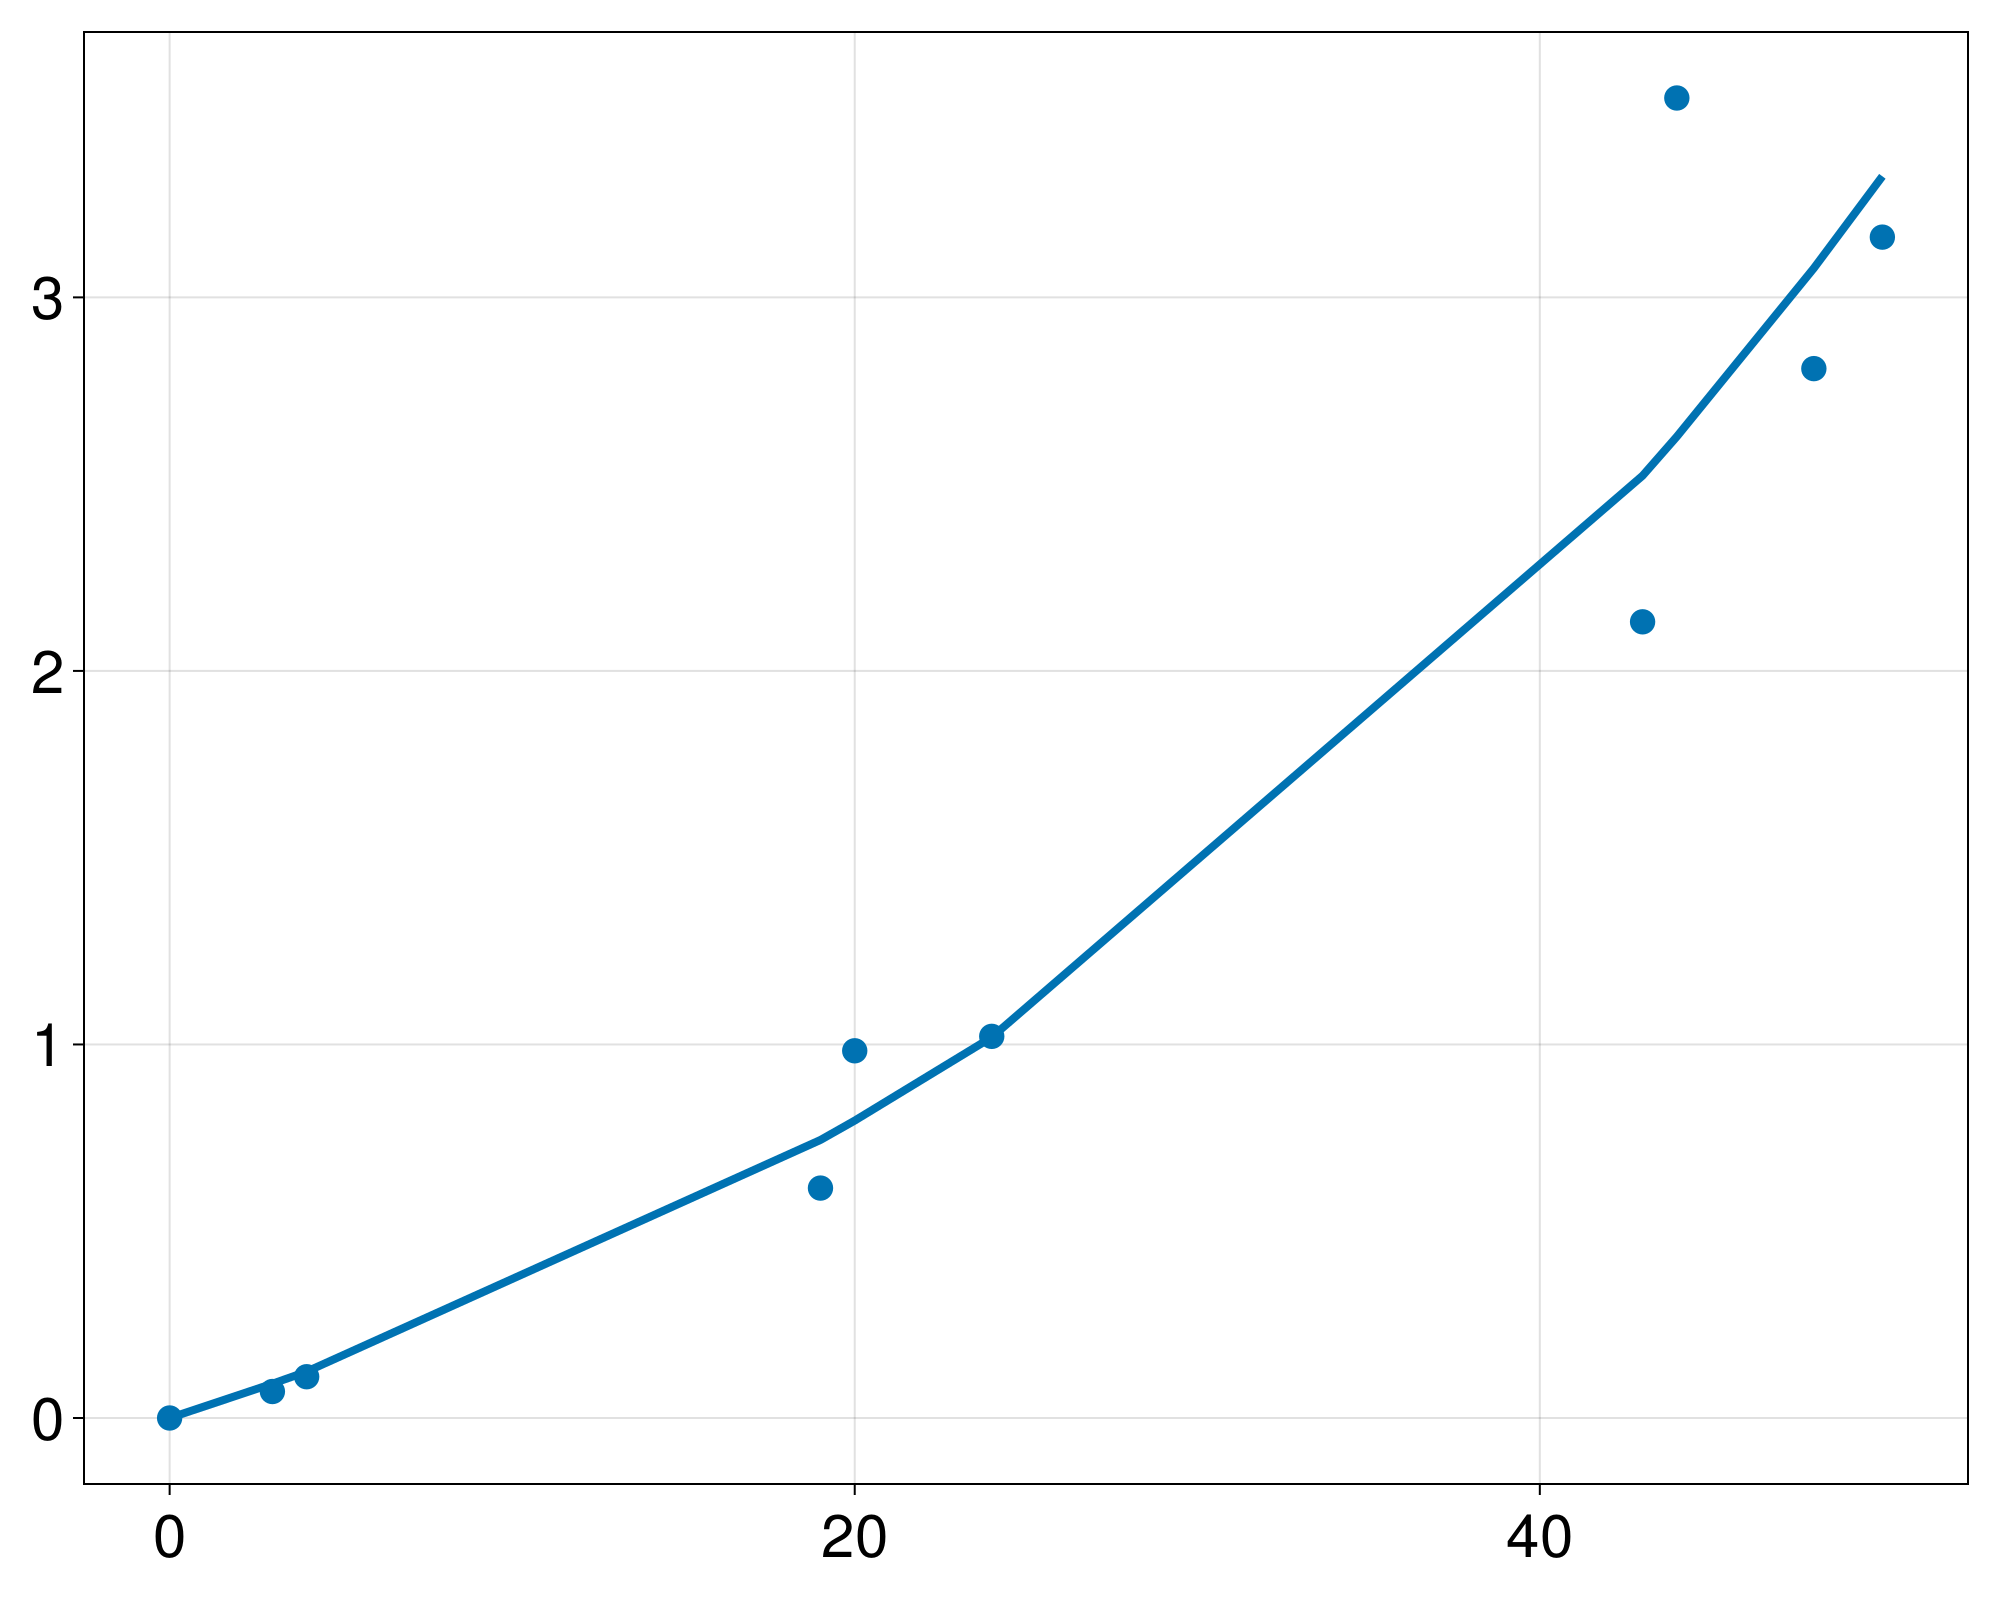

In [72]:
fig10 =scatter(size_data.time, size_data.abs_size_normalized)
lines!(fig10.axis, size_data.time, y2.-1)
fig10

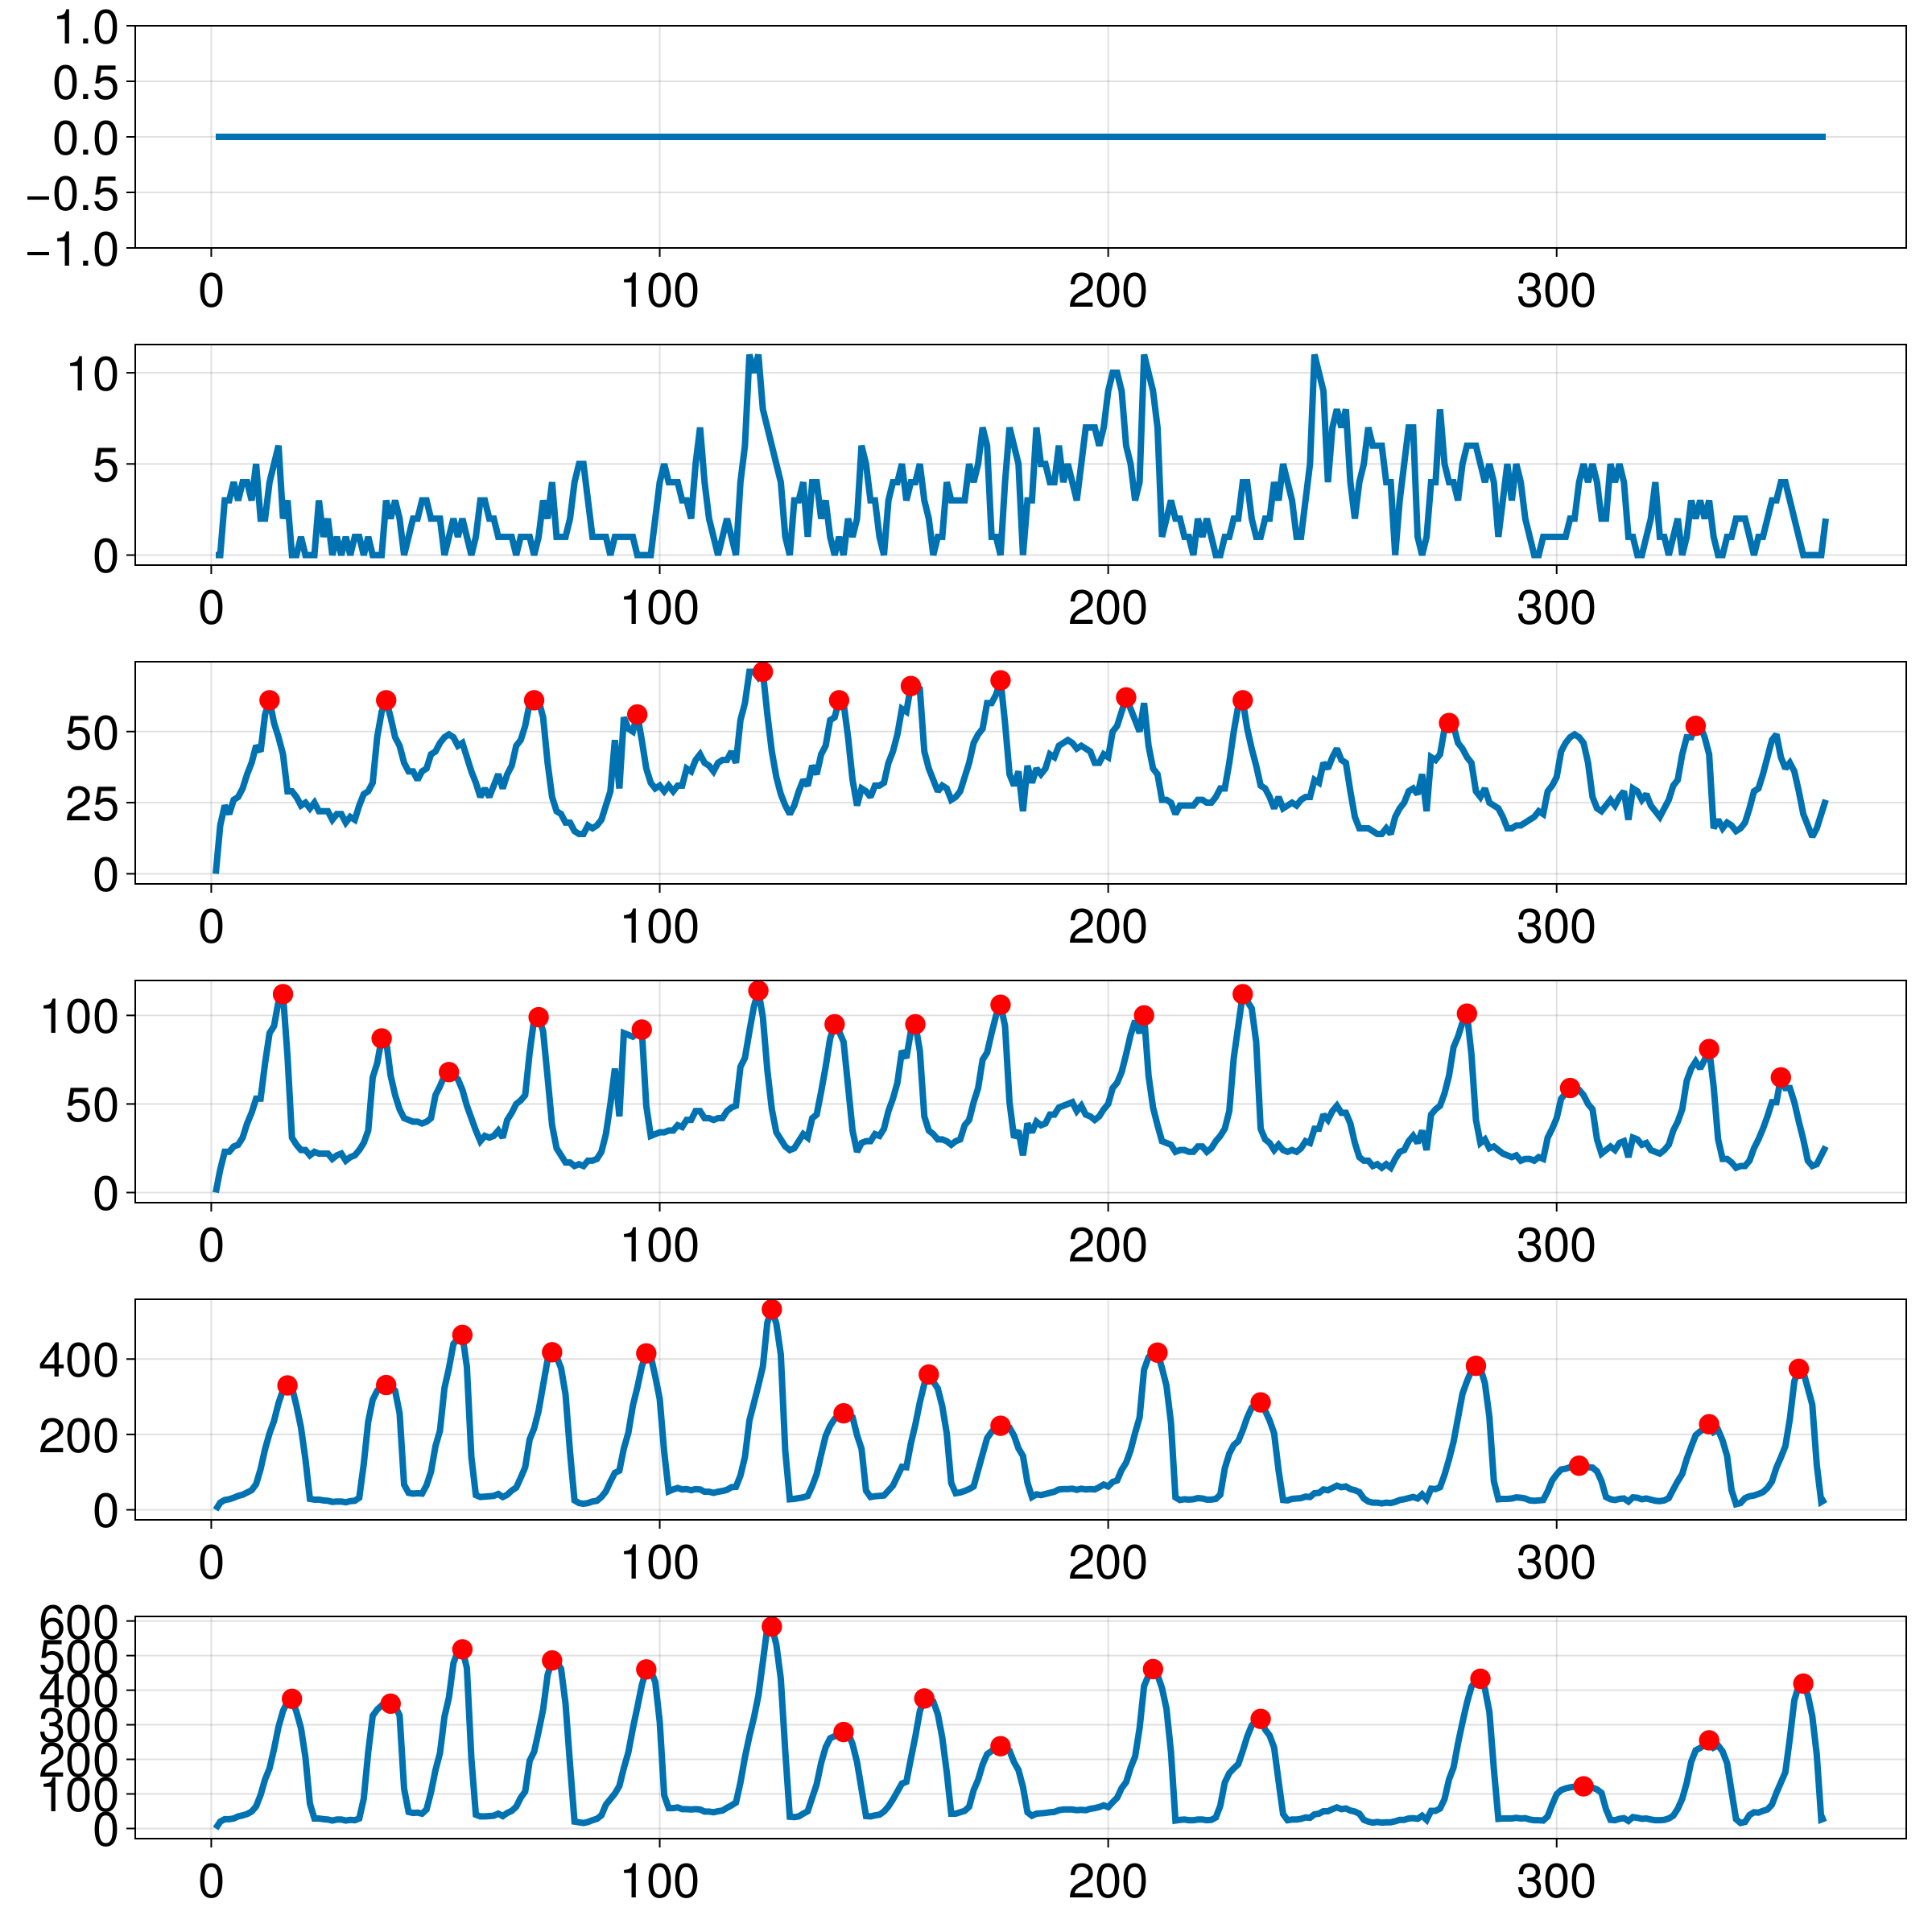

In [51]:
fig6 = Figure(size =(1200,1200))
for i in 1:6
    data1 = data_full.metric_OG[i+6];
    ax = CairoMakie.Axis(fig6[i,1])
    lines!(ax, data1)
    pkindices, properties = findpeaks1d(data1, prominence=0.6*mean(data1), distance = 4, height = 50)
    scatter!(ax, pkindices, data1[[pkindices...]],color = "red" )
end
fig6

In [52]:
peaks_full  = @chain data_full begin 
    @transform(:nr_peaks_OG = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 40)[1] for i in :metric_OG])  )
end
first(peaks_full)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,nr_peaks_OG
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Int64
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,0


In [54]:
peaks_over_time = @chain peaks_full begin
    groupby([:time])
    @combine(:peaks_mean = mean(:nr_peaks_OG), :peaks_stdd =std(:nr_peaks_OG) )
end


Row,time,peaks_mean,peaks_stdd
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,0.375,1.06066
3,4,0.0,0.0
4,19,11.875,4.01559
5,20,14.8333,1.16905
6,24,12.5,2.5579
7,43,14.625,1.50594
8,44,13.1667,1.94079
9,48,13.0714,1.69812


In [55]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean = mean(:nr_peaks_OG), :peaks_stdd =std(:nr_peaks_OG) )
end

Row,time,data_set,peaks_mean,peaks_stdd
,Int64,String,Float64,Float64
1,0,14_06_23_stacked_full_res,0.0,0.0
2,4,14_06_23_stacked_full_res,0.0,0.0
3,20,14_06_23_stacked_full_res,14.8333,1.16905
4,24,14_06_23_stacked_full_res,14.8333,0.983192
5,44,14_06_23_stacked_full_res,13.1667,1.94079
6,48,14_06_23_stacked_full_res,12.8333,2.31661
7,0,17_05_23_stacked_full_res,0.0,0.0
8,24,17_05_23_stacked_full_res,12.2857,2.33464
9,48,17_05_23_stacked_full_res,12.2857,0.726273


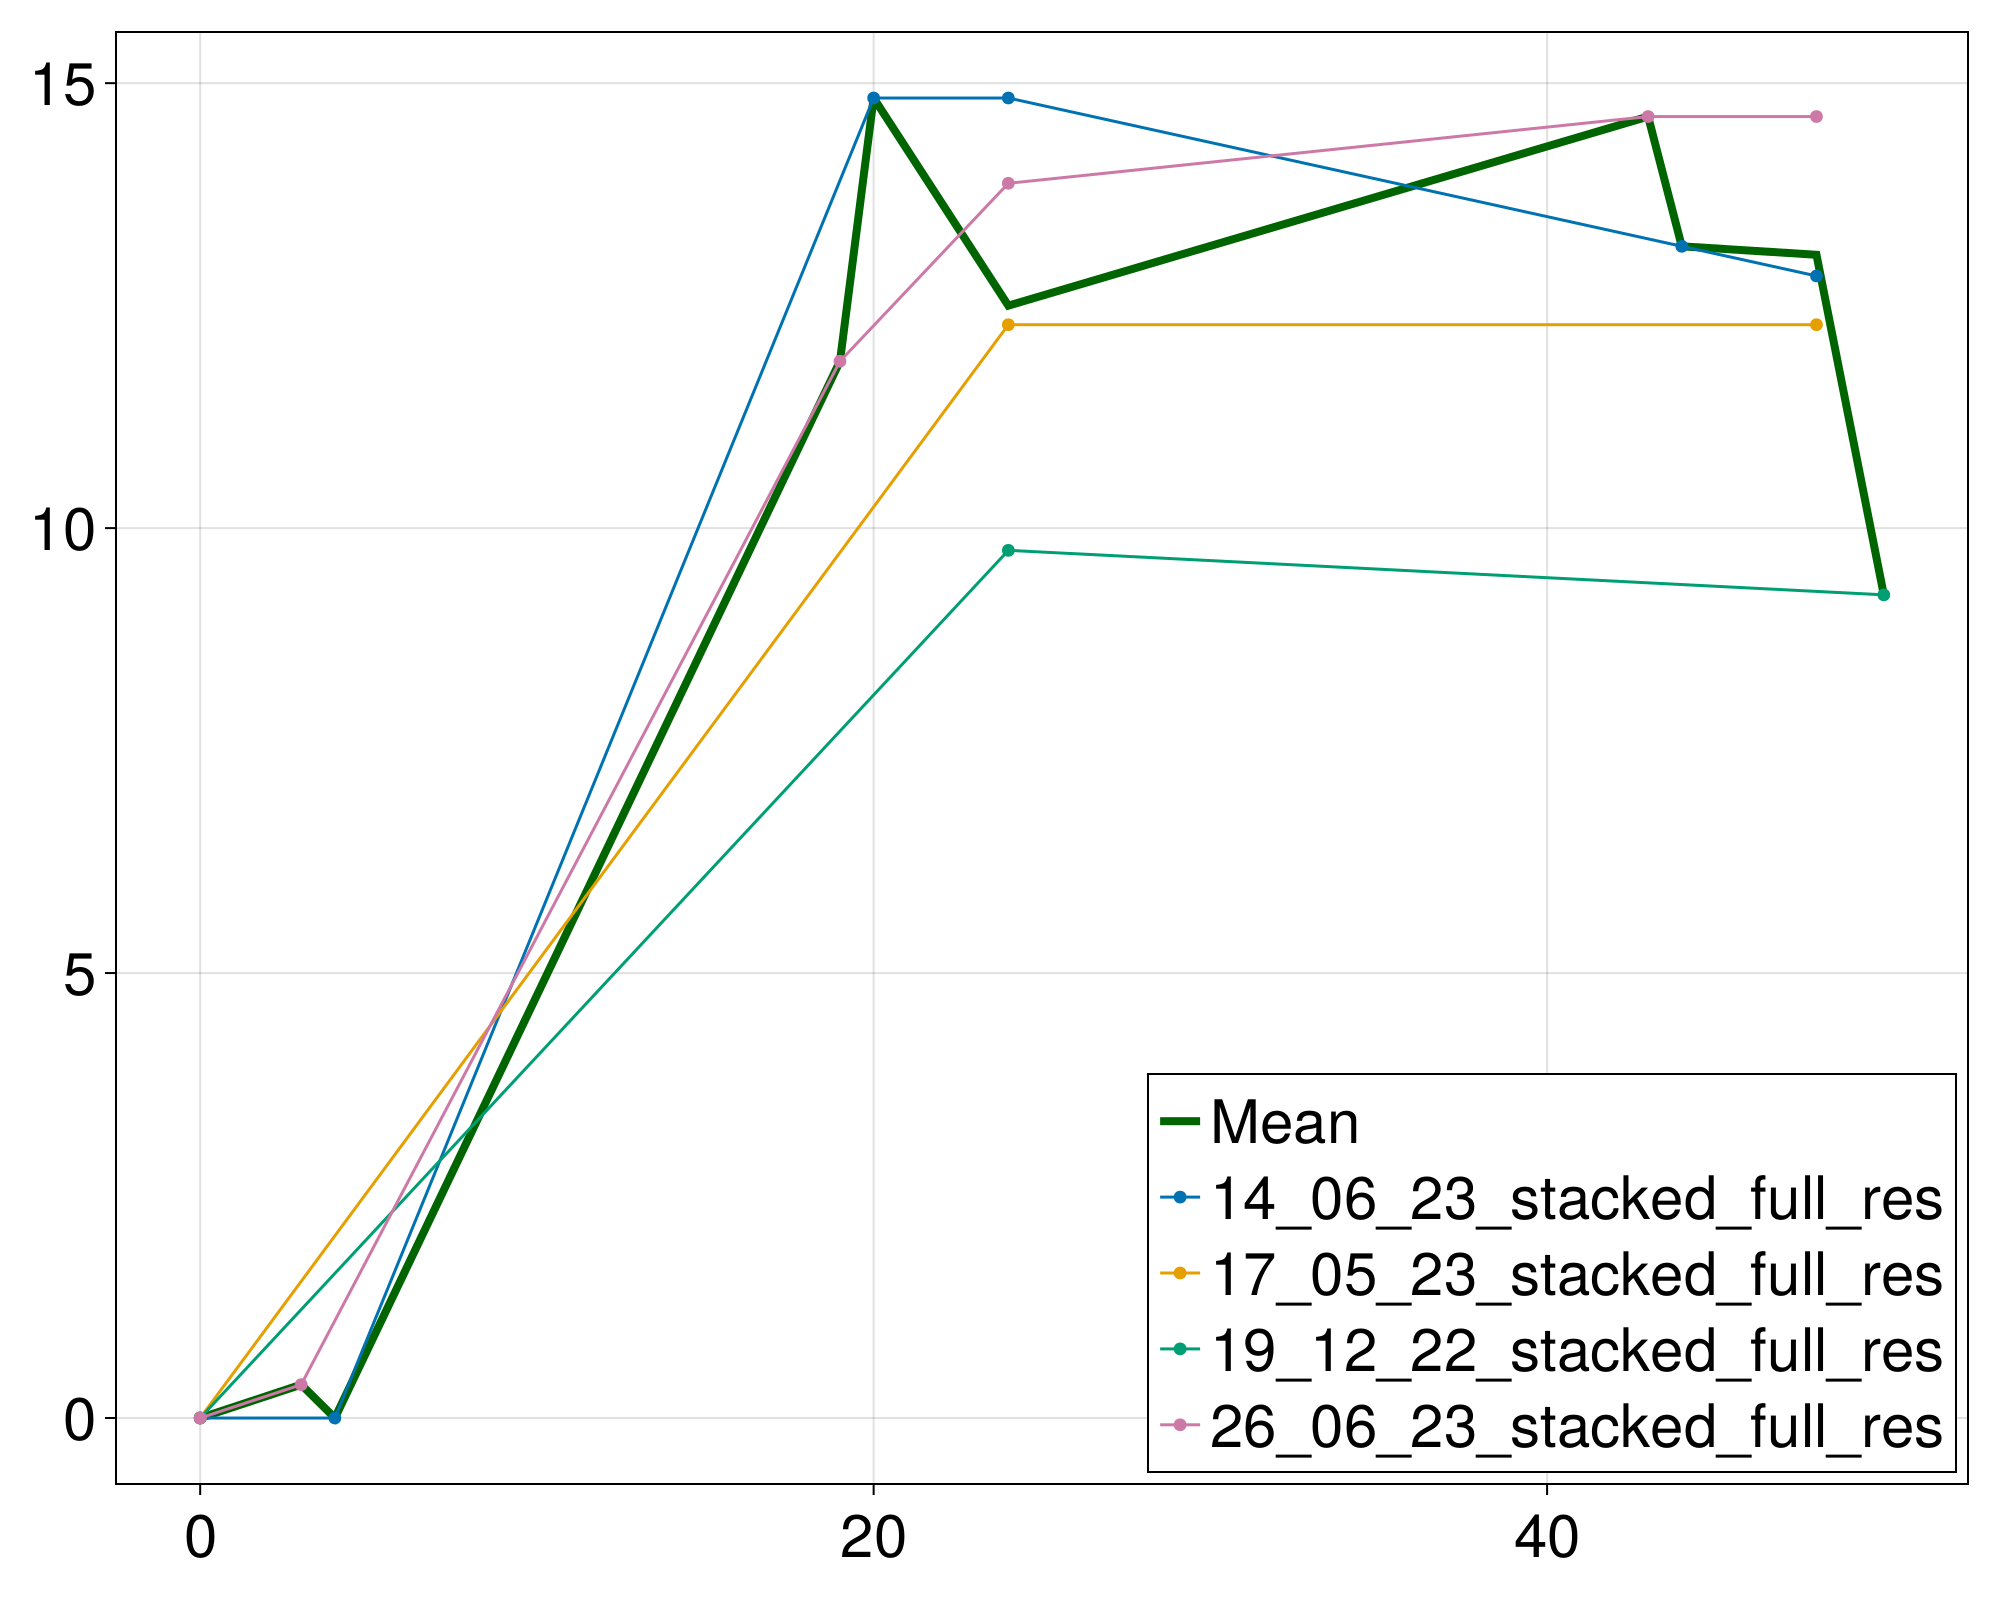

In [58]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatterlines!(fig7.axis, i.time, i.peaks_mean, label = String(k.data_set))
end
axislegend(fig7.axis, position = :rb)
fig7


In [60]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

LoadError: UndefVarError: `df_f` not defined